Dependencies

In [5]:
!pip install kmodes

In [6]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Load the data

In [112]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the file path
file_path = '/content/drive/My Drive/Unsupervised Learning 23-24 - Project Dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
# Load the dataset
df = pd.read_csv(file_path, sep=';', decimal=',')

# Display the first few rows of the dataframe
df.head(10)

,Row,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,...,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20,Unnamed: 22,Unnamed: 23
0,0,0.750000,1,0,1,1,1,1,1,0,...,1,1,1,0.001132,0.080780,0.197324,0.300926,0.225000,NaN,NaN
1,1,0.239583,1,1,1,1,1,1,1,1,...,1,1,1,0.000472,0.164345,0.235786,0.537037,0.165625,NaN,NaN
2,2,0.479167,1,1,1,1,1,1,1,1,...,1,1,1,0.003585,0.130919,0.167224,0.527778,0.118750,NaN,NaN
3,3,0.656250,0,1,1,1,1,1,1,1,...,1,1,1,0.001698,0.091922,0.125418,0.337963,0.129688,NaN,NaN
4,4,0.229167,1,1,1,1,1,1,1,1,...,1,1,1,0.000472,0.142061,0.229097,0.337963,0.235938,NaN,NaN
5,5,0.708333,0,1,1,1,1,1,1,1,...,1,1,1,0.000472,0.086351,0.140468,0.245370,0.189063,NaN,NaN
6,6,0.875000,0,1,1,1,1,1,1,1,...,1,1,1,0.000472,0.125348,0.210702,0.402778,0.185937,NaN,NaN
7,7,0.489583,0,1,1,1,1,1,1,1,...,1,1,1,0.003925,0.108635,0.140468,0.282407,0.168750,NaN,NaN
8,8,0.687500,1,0,1,1,1,1,1,1,...,1,1,1,0.002453,0.130919,0.142140,0.425926,0.121875,NaN,NaN
9,9,0.781250,1,1,1,1,1,1,1,1,...,1,1,1,0.000189,0.158774,0.204013,0.513889,0.148438,NaN,NaN


In [114]:
df.drop(df.columns[0], axis=1, inplace=True)
df.drop(df.columns[-2:], axis=1, inplace=True)

Pre-analysis

In [115]:
# get continuous and binary columns, and their indices
continuous_columns = df.iloc[:, [0] + list(range(-5, 0))]
continuous_indices = [0] + list(range(-5, 0))
binary_columns = df.drop(continuous_columns.columns, axis=1)
binary_indices = list(range(1, 16))

In [ ]:
print("Statistics for the continuous columns:")
print(continuous_columns.describe())

Statistics for the continuous columns:
             Dim_0       Dim_16       Dim_17       Dim_18       Dim_19  \
count  7200.000000  7200.000000  7200.000000  7200.000000  7200.000000   
mean      0.531790     0.009172     0.108506     0.179649     0.374250   
std       0.197156     0.043357     0.042001     0.060148     0.088354   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.375000     0.001340     0.091922     0.145485     0.324074   
50%       0.562500     0.003208     0.109192     0.175585     0.370370   
75%       0.687500     0.005094     0.119777     0.205686     0.402778   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Dim_20  
count  7200.000000  
mean      0.173773  
std       0.056402  
min       0.000000  
25%       0.145312  
50%       0.170313  
75%       0.195313  
max       1.000000  


In [13]:
# Get the count of unique values for each binary column
binary_counts = {}
for column in binary_columns.columns:
    binary_counts[column] = binary_columns[column].value_counts()

In [ ]:
print("\nCount of unique values for binary columns: \n")
for column, counts in binary_counts.items():
    print(counts, '\n')


Count of unique values for binary columns: 

Dim_1=0
1    5009
0    2191
Name: count, dtype: int64 

Dim_2=0
1    6260
0     940
Name: count, dtype: int64 

Dim_3=0
1    7089
0     111
Name: count, dtype: int64 

Dim_4=0
1    7108
0      92
Name: count, dtype: int64 

Dim_5=0
1    6924
0     276
Name: count, dtype: int64 

Dim_6=0
1    7122
0      78
Name: count, dtype: int64 

Dim_7=0
1    7099
0     101
Name: count, dtype: int64 

Dim_8=0
1    7079
0     121
Name: count, dtype: int64 

Dim_9=0
1    6728
0     472
Name: count, dtype: int64 

Dim_10=0
1    6705
0     495
Name: count, dtype: int64 

Dim_11=0
1    7109
0      91
Name: count, dtype: int64 

Dim_12=0
1    7141
0      59
Name: count, dtype: int64 

Dim_13=0
1    7016
0     184
Name: count, dtype: int64 

Dim_14=0
1    7199
0       1
Name: count, dtype: int64 

Dim_15=0
1    6848
0     352
Name: count, dtype: int64 



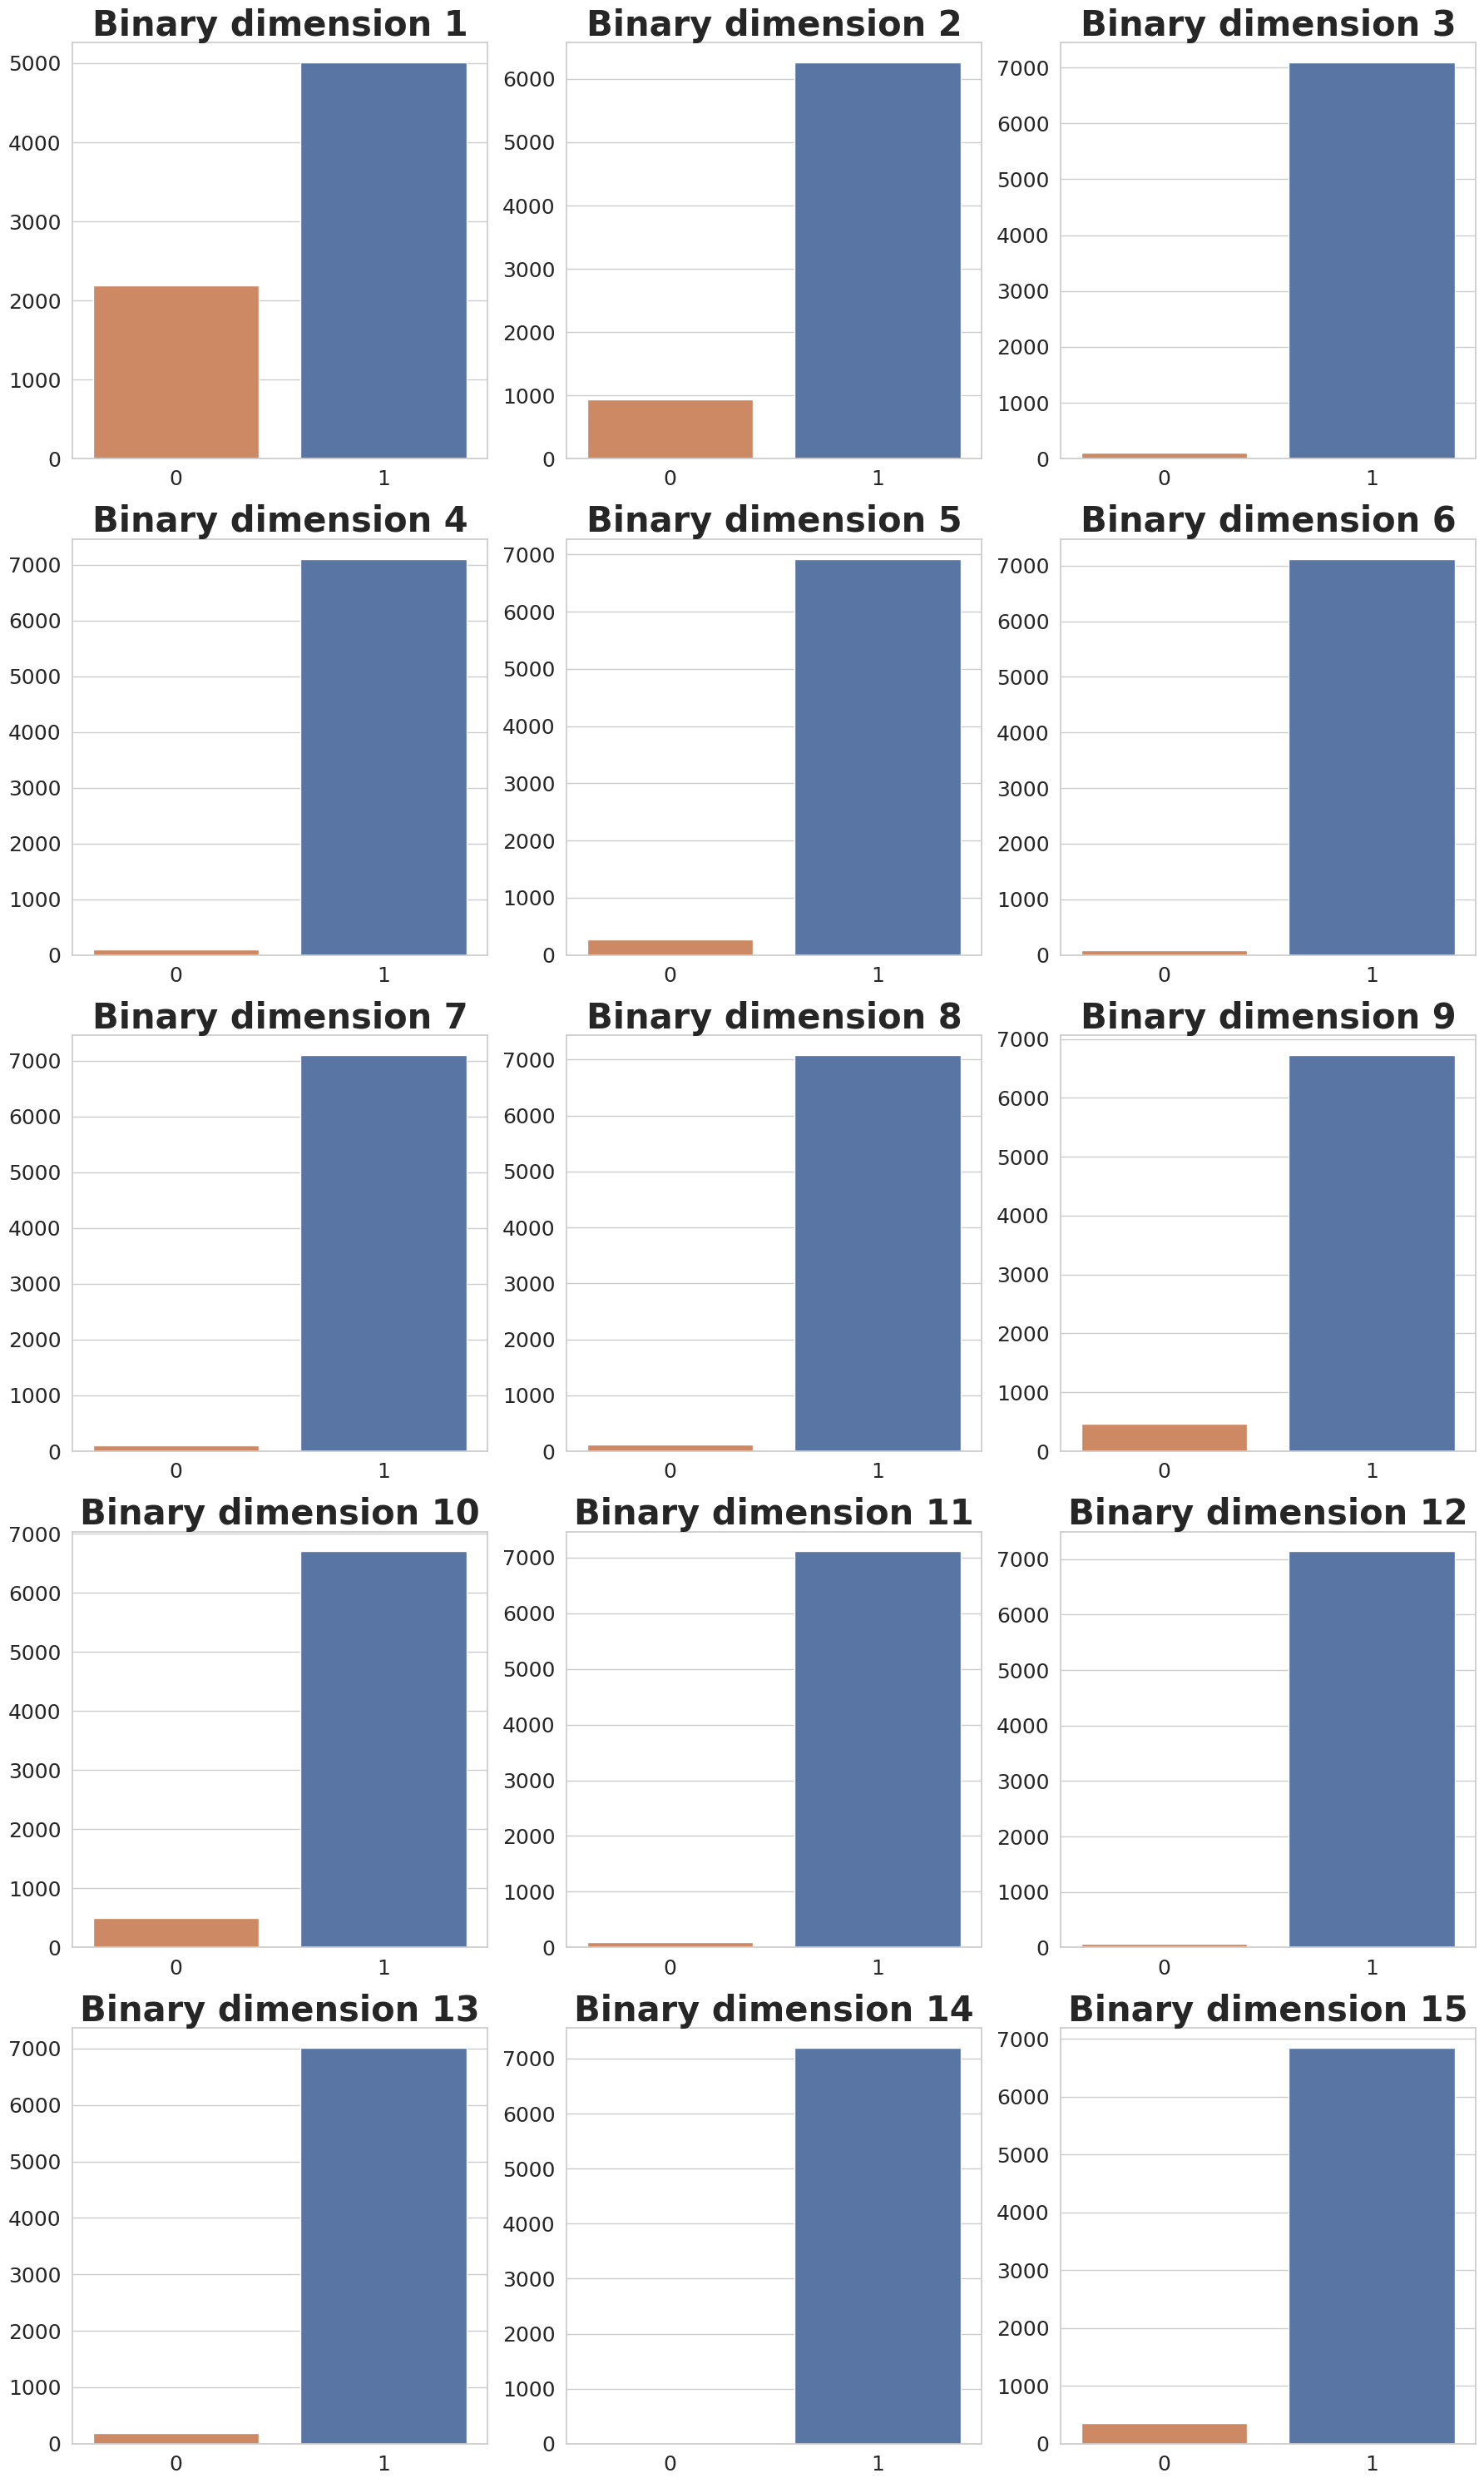

In [48]:
# plot the binary columns counts
num_plots = len(binary_columns.columns)
num_rows = (num_plots // 3) + (num_plots % 3 > 0)
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6*num_rows))
axes = axes.flatten()

def rename_column(column):
    return column.replace('Dim_', 'Binary dimension ').replace('=0', '')

for i, (column, counts) in enumerate(binary_counts.items()):
    sns.barplot(x=counts.index, y=counts.values, hue=[0, 1], ax=axes[i], palette="deep")
    axes[i].set_title(rename_column(column), fontsize=30, weight='bold')
    axes[i].set(xlabel=None)
    axes[i].tick_params(axis='both', which='major', labelsize=18)
    axes[i].legend([],[], frameon=False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

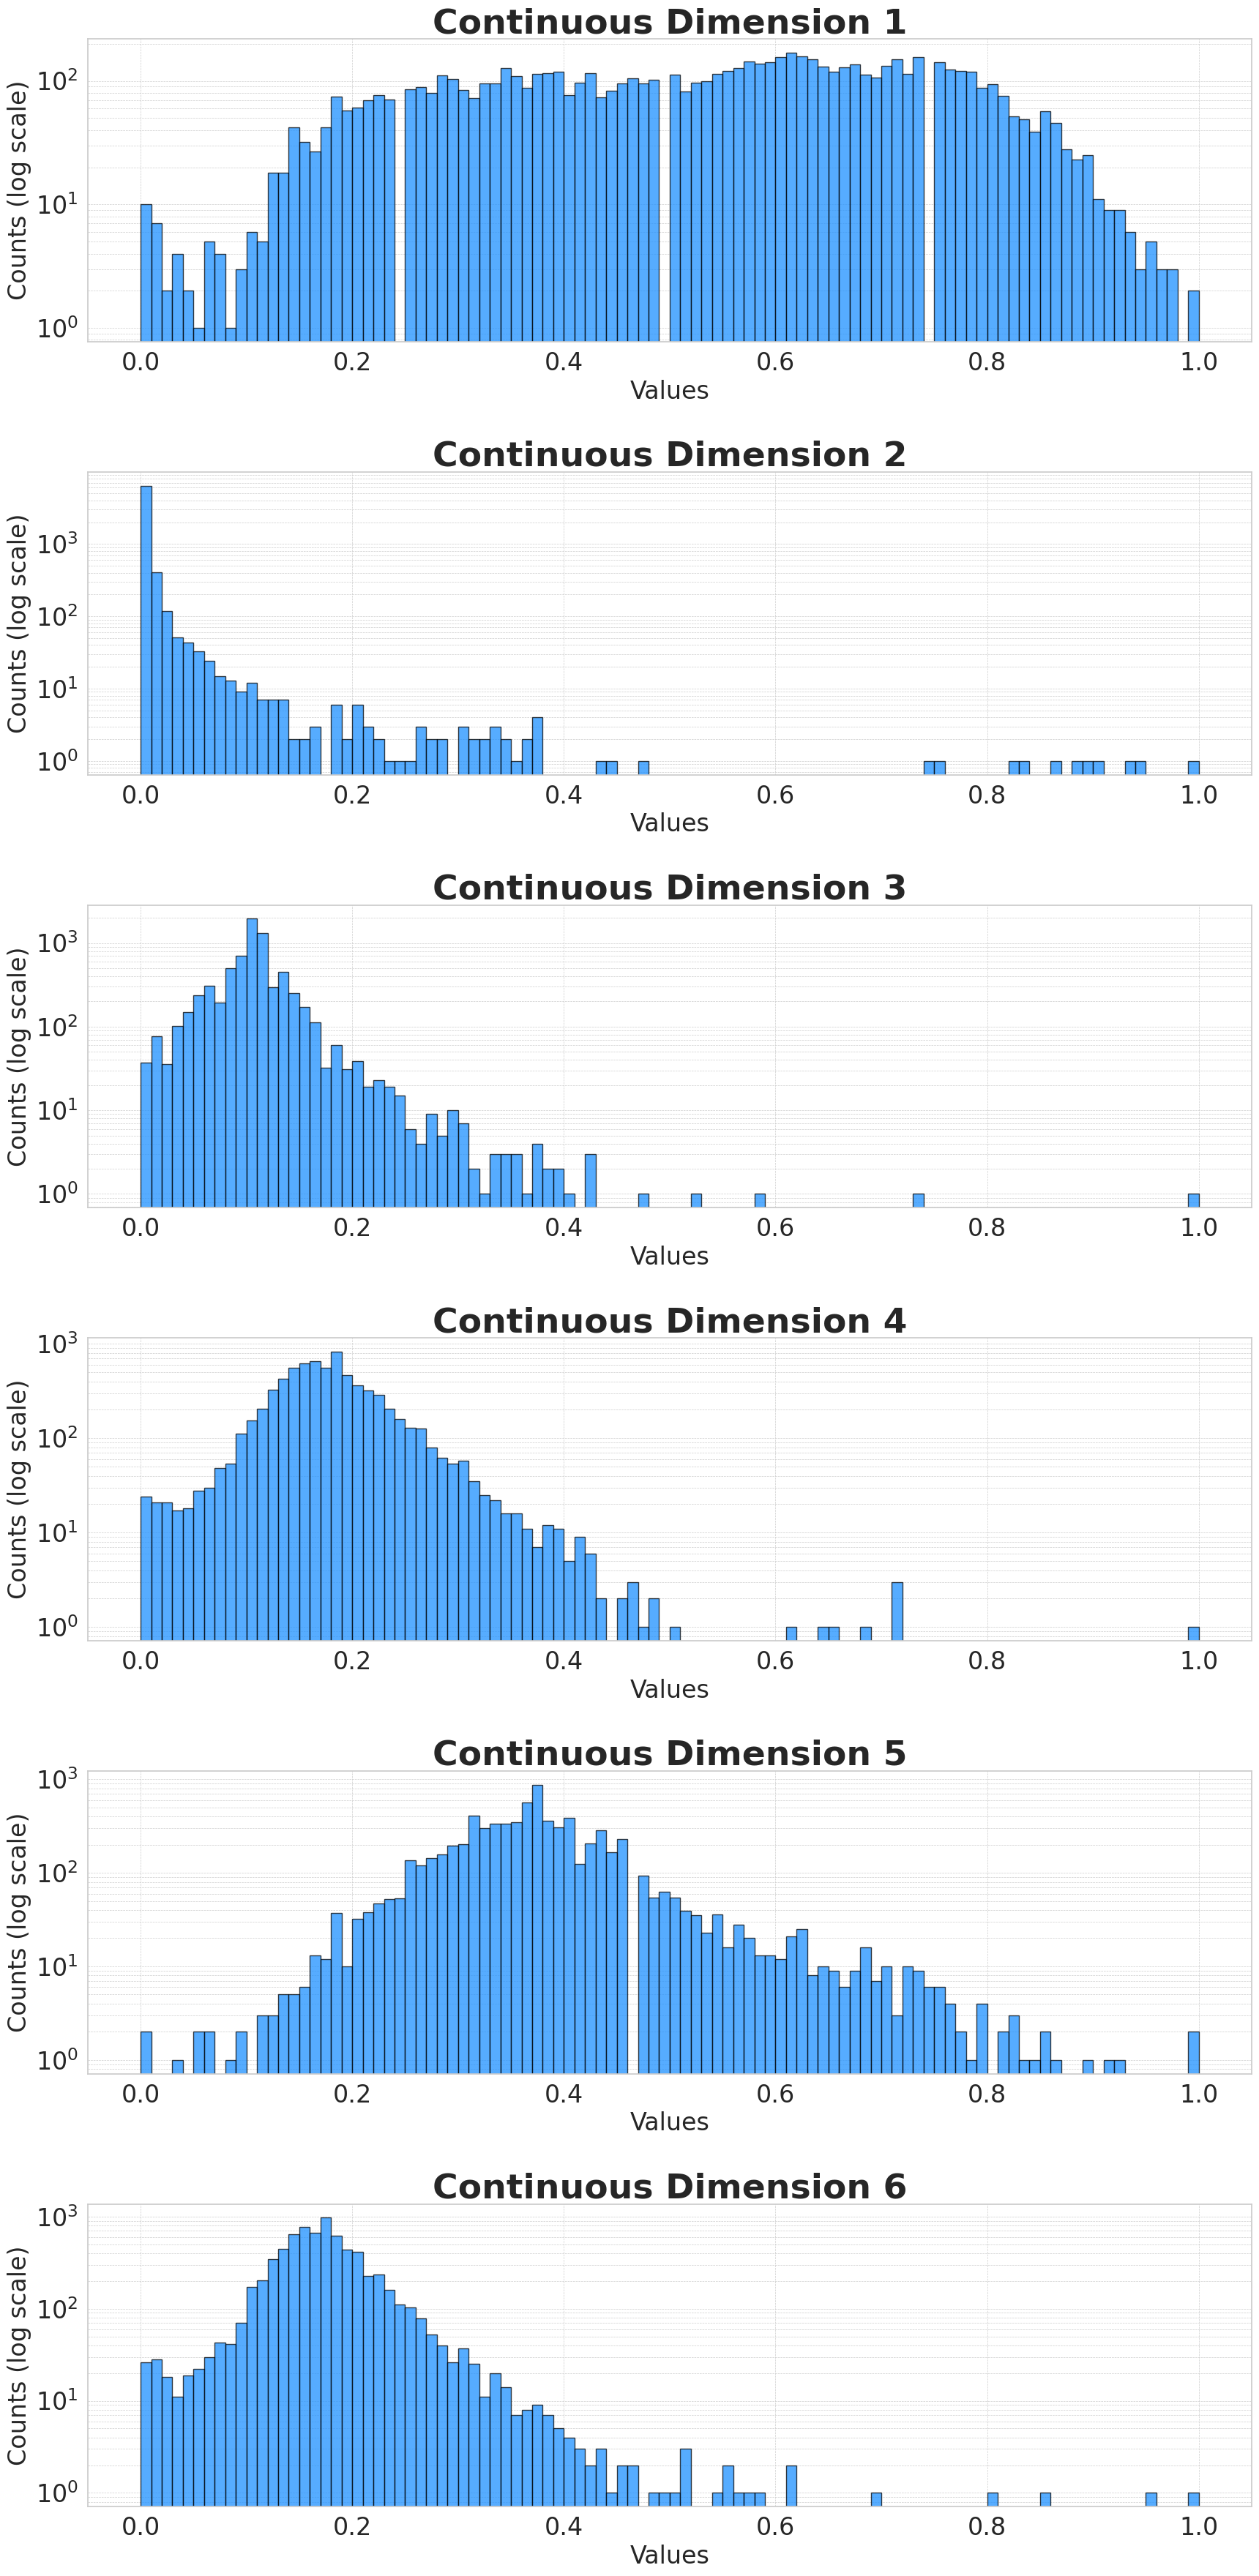

In [47]:
# plot the distribution of continuous values
num_columns = len(continuous_columns.columns)
plt.figure(figsize=(18, 6 * num_columns))

for i, column in enumerate(continuous_columns.columns):
    plt.subplot(num_columns, 1, i + 1)
    plt.hist(continuous_columns[column], bins=100, alpha=0.75, color='dodgerblue', edgecolor='black', log=True)
    plt.title(f'Continuous Dimension {i + 1}', fontsize=34, weight='bold')
    plt.xlabel('Values', fontsize=24)
    plt.ylabel('Counts (log scale)', fontsize=24)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

plt.tight_layout(pad=3.0)
plt.show()

In [38]:
# Get the unique value counts for binary columns
unique_rows = binary_columns.drop_duplicates()
unique_rows.shape

(135, 15)

# Anomaly detection

Define models that will be used for anomaly detection

In [116]:
class KProto():
    """
    A class used to perform K-Prototypes clustering on a dataset with both
    continuous and binary attributes and to identify anomalies based on the clustering.

    Attributes
    ----------
    data : DataFrame
        The dataset to be clustered.
    binary_indices : list
        Indices of binary attributes in the dataset.
    continuous_indices : list
        Indices of continuous attributes in the dataset.

    Methods
    -------
    fit(n_clusters, n_init=5, init='Huang', scaler=StandardScaler()):
        Preprocess the data, normalize continuous attributes if a scaler is provided,
        and fit the K-Prototypes model to the data.
    find_anomalies(threshold_percentile=95):
        Calculate the cost for each point, define a threshold for anomalies, and identify anomalies.
    compute_distance():
        Compute the distance of each data point from its cluster centroid.
    display_anomalies(only_anomalies=True):
        Display the dataset with cluster assignments, distances from centroids,
        and anomaly labels. Optionally display only anomalies.
    """

    def __init__(self, data, binary_indices, continuous_indices):
        """
        Initialize the KProto class with the dataset and attribute indices.

        Parameters
        ----------
        data : DataFrame
            The dataset to be clustered.
        binary_indices : list
            Indices of binary attributes in the dataset.
        continuous_indices : list
            Indices of continuous attributes in the dataset.
        """
        self.data = data
        self.binary_indices = binary_indices
        self.continuous_indices = continuous_indices

    def fit(self, n_clusters, n_init=5, init='Huang', scaler=StandardScaler()):
        """
        Preprocess the data, normalize continuous attributes if a scaler is provided,
        and fit the K-Prototypes model to the data.

        Parameters
        ----------
        n_clusters : int
            The number of clusters to form.
        n_init : int, optional
            Number of times the K-Prototypes algorithm will be run with different centroid seeds (default is 5).
        init : str, optional
            Method for initialization ('Huang', 'Cao', 'random' or an ndarray) (default is 'Huang').
        scaler : object, optional
            Scaler object to normalize continuous attributes (default is StandardScaler()).
        """
        # scale data
        if scaler is not None:
            self.scaler = scaler
            continuous_columns = self.data.iloc[:, self.continuous_indices].columns
            continuous_normalized = self.scaler.fit_transform(self.data.iloc[:, self.continuous_indices])
            normalized_continuous_columns = pd.DataFrame(continuous_normalized, columns=continuous_columns)
            data_preprocessed = self.data.copy(deep=True)
            data_preprocessed[continuous_columns] = normalized_continuous_columns
        else:
            data_preprocessed = self.data.copy(deep=True)
        self.data_matrix = data_preprocessed.to_numpy()
        # fit K Prototypes
        self.kproto = KPrototypes(n_clusters=n_clusters, init=init, n_init=n_init, verbose=1)
        self.clusters = self.kproto.fit_predict(self.data_matrix, categorical=self.binary_indices)
        self.centroids = self.kproto.cluster_centroids_
        self.gamma = self.kproto.gamma

    def find_anomalies(self, threshold_percentile=95):
        """
        Calculate the cost for each point, define a threshold for anomalies, and identify anomalies.

        Parameters
        ----------
        threshold_percentile : int, optional
            The percentile of distances to use as the threshold for defining anomalies (default is 95).

        Returns
        -------
        ndarray
            Boolean array indicating which points are anomalies.
        """
        # Calculate the cost for each point
        distances = self.compute_distance()
        # Define a threshold for anomalies
        self.threshold = np.percentile(distances, threshold_percentile)
        # Identify anomalies
        self.anomalies = distances > self.threshold

        return self.anomalies

    def compute_distance(self):
        """
        Compute the distance of each data point from its cluster centroid.

        Returns
        -------
        ndarray
            Array of distances for each data point.
        """
        distances = np.zeros(self.data_matrix.shape[0])
        for i, x in enumerate(self.data_matrix):
            cluster = self.clusters[i]
            centroid = self.centroids[cluster]
            dist = 0
            for j in range(len(x)):
                if j in self.binary_indices:
                    dist += self.gamma * (x[j] != centroid[j])
                else:
                    dist += (x[j] - centroid[j]) ** 2
            distances[i] = dist
        self.distances = distances
        return distances

    def display_anomalies(self, only_anomalies=True):
        """
        Display the dataset with cluster assignments, distances from centroids, and anomaly labels.

        Parameters
        ----------
        only_anomalies : bool, optional
            If True, return only the anomalies (default is True).

        Returns
        -------
        DataFrame
            DataFrame containing the dataset with additional columns for clusters, distances, and anomaly labels.
        """
        df_copy = self.data.copy(deep=True)
        df_copy['Cluster'] = self.clusters
        df_copy['Distance'] = self.distances
        df_copy['Anomaly'] = self.anomalies

        if only_anomalies:
            return df_copy[df_copy['Anomaly'] == True]
        else:
            return df_copy

In [117]:
class InformationGainAnomalyDetection():
    """
    A class used to perform anomaly detection based on information gain,
    considering both continuous and binary attributes.

    Attributes
    ----------
    data : DataFrame
        The dataset for anomaly detection.
    binary_indices : list
        Indices of binary attributes in the dataset.
    continuous_indices : list
        Indices of continuous attributes in the dataset.

    Methods
    -------
    fit(bins=50, scaler=StandardScaler()):
        Preprocess the data, normalize continuous attributes if a scaler is provided,
        and compute the initial entropy of the dataset.
    compute_entropy(data_matrix, continuous_indices, binary_indices, bins=50):
        Compute the entropy of the given dataset, handling both binary and continuous data.
    find_anomalies(bins=50, threshold_percentile=95):
        Compute the anomaly scores by calculating the change in entropy without each observation,
        and identify anomalies based on a specified percentile threshold.
    display_anomalies(only_anomalies=True):
        Display the dataset with anomaly scores and labels, optionally showing only the anomalies.
    """

    def __init__(self, data, binary_indices, continuous_indices):
        """
        Initialize the InformationGainAnomalyDetection class with the dataset and attribute indices.

        Parameters
        ----------
        data : DataFrame
            The dataset for anomaly detection.
        binary_indices : list
            Indices of binary attributes in the dataset.
        continuous_indices : list
            Indices of continuous attributes in the dataset.
        """
        self.data = data
        self.binary_indices = binary_indices
        self.continuous_indices = continuous_indices

    def fit(self, bins=50, scaler=StandardScaler()):
        """
        Preprocess the data, normalize continuous attributes if a scaler is provided,
        and compute the initial entropy of the dataset.

        Parameters
        ----------
        bins : int, optional
            Number of bins for histogram computation (default is 50).
        scaler : object, optional
            Scaler object to normalize continuous attributes (default is StandardScaler()).
        """
        if scaler is not None:
            self.scaler = scaler
            continuous_columns = self.data.iloc[:, self.continuous_indices].columns
            continuous_normalized = self.scaler.fit_transform(self.data.iloc[:, self.continuous_indices])
            normalized_continuous_columns = pd.DataFrame(continuous_normalized, columns=continuous_columns)
            data_preprocessed = self.data.copy(deep=True)
            data_preprocessed[continuous_columns] = normalized_continuous_columns
        else:
            data_preprocessed = self.data.copy(deep=True)
        self.data_matrix = data_preprocessed.to_numpy()

        # Compute the initial entropy
        self.initial_entropy = self.compute_entropy(self.data_matrix, self.continuous_indices, self.binary_indices, bins)

    def compute_entropy(self, data_matrix, continuous_indices, binary_indices, bins=50):
        """
        Compute the entropy of the given dataset.
        Handles both binary and continuous data.

        Parameters
        ----------
        data_matrix : ndarray
            The preprocessed dataset as a NumPy array.
        continuous_indices : list
            Indices of continuous attributes in the dataset.
        binary_indices : list
            Indices of binary attributes in the dataset.
        bins : int, optional
            Number of bins for histogram computation (default is 50).

        Returns
        -------
        float
            The combined entropy of the continuous and binary data.
        """
        n = len(data_matrix)

        # Separate continuous and binary data
        data_continuous = data_matrix[:, continuous_indices]
        data_binary = data_matrix[:, binary_indices]

        # Compute entropy for continuous data
        hist, bin_edges = np.histogram(data_continuous, bins=bins, density=True)
        hist = hist[hist > 0]  # Remove zero entries to avoid log(0)
        probabilities_cont = hist / np.sum(hist)
        entropy_cont = -np.sum(probabilities_cont * np.log2(probabilities_cont))

        # Compute entropy for binary data
        _, counts = np.unique(data_binary, return_counts=True, axis=0)
        probabilities_binary = counts / n
        entropy_binary = -np.sum(probabilities_binary * np.log2(probabilities_binary))

        # Combine entropies
        combined_entropy = entropy_cont + entropy_binary

        return combined_entropy

    def find_anomalies(self, bins=50, threshold_percentile=95):
        """
        Compute the anomaly scores by calculating the change in entropy without each observation,
        and identify anomalies based on a specified percentile threshold.

        Parameters
        ----------
        bins : int, optional
            Number of bins for histogram computation (default is 50).
        threshold_percentile : int, optional
            The percentile of anomaly scores to use as the threshold for defining anomalies (default is 95).

        Returns
        -------
        ndarray
            Boolean array indicating which points are anomalies.
        """
        self.anomaly_scores = np.zeros(self.data_matrix.shape[0])

        # Compute the entropy without each observation
        for i in range(self.data_matrix.shape[0]):
            data_without_i = np.delete(self.data_matrix, i, axis=0)
            entropy_without_i = self.compute_entropy(data_without_i, self.continuous_indices, self.binary_indices, bins)
            self.anomaly_scores[i] = np.abs(self.initial_entropy - entropy_without_i)

        # Define a threshold for anomalies
        self.threshold = np.percentile(self.anomaly_scores, threshold_percentile)

        # Identify anomalies
        self.anomalies = self.anomaly_scores > self.threshold

        return self.anomalies

    def display_anomalies(self, only_anomalies=True):
        """
        Display the dataset with anomaly scores and labels, optionally showing only the anomalies.

        Parameters
        ----------
        only_anomalies : bool, optional
            If True, return only the anomalies (default is True).

        Returns
        -------
        DataFrame
            DataFrame containing the dataset with additional columns for anomaly scores and labels.
        """
        df_copy = self.data.copy(deep=True)
        df_copy['AnomalyScore'] = self.anomaly_scores
        df_copy['Anomaly'] = self.anomalies

        if only_anomalies:
            return df_copy[df_copy['Anomaly'] == True]
        else:
            return df_copy

In [118]:
class CombinedAnomalyDetection():
    """
    A class used to perform anomaly detection by combining KMeans clustering for continuous data
    and information gain for binary data.

    Attributes
    ----------
    data : DataFrame
        The dataset for anomaly detection.
    binary_indices : list
        Indices of binary attributes in the dataset.
    continuous_indices : list
        Indices of continuous attributes in the dataset.

    Methods
    -------
    fit(n_clusters=3, n_init=5, scaler=StandardScaler()):
        Preprocess the data, normalize continuous attributes if a scaler is provided,
        fit the KMeans model to the continuous data, and compute the initial entropy for binary data.
    compute_entropy(data_binary):
        Compute the entropy of the given binary dataset.
    compute_distance():
        Compute the distance of each data point from its cluster centroid for continuous data.
    information_gain_anomaly_detection():
        Compute anomaly scores for binary data based on information gain.
    combine_scores(continuous_scores, binary_scores, w1=0.5, w2=0.5):
        Combine the continuous and binary anomaly scores using a weighted average.
    find_anomalies(threshold_percentile=95):
        Compute and combine anomaly scores, then identify anomalies based on a specified percentile threshold.
    display_anomalies(only_anomalies=True):
        Display the dataset with continuous, binary, and combined anomaly scores, optionally showing only the anomalies.
    """

    def __init__(self, data, binary_indices, continuous_indices):
        """
        Initialize the CombinedAnomalyDetection class with the dataset and attribute indices.

        Parameters
        ----------
        data : DataFrame
            The dataset for anomaly detection.
        binary_indices : list
            Indices of binary attributes in the dataset.
        continuous_indices : list
            Indices of continuous attributes in the dataset.
        """
        self.data = data
        self.binary_indices = binary_indices
        self.continuous_indices = continuous_indices

    def fit(self, n_clusters=3, n_init=5, scaler=StandardScaler()):
        """
        Preprocess the data, normalize continuous attributes if a scaler is provided,
        fit the KMeans model to the continuous data, and compute the initial entropy for binary data.

        Parameters
        ----------
        n_clusters : int, optional
            The number of clusters to form (default is 3).
        n_init : int, optional
            Number of times the KMeans algorithm will be run with different centroid seeds (default is 5).
        scaler : object, optional
            Scaler object to normalize continuous attributes (default is StandardScaler()).
        """
        if scaler is not None:
            self.scaler = scaler
            continuous_columns = self.data.iloc[:, self.continuous_indices].columns
            continuous_normalized = self.scaler.fit_transform(self.data.iloc[:, self.continuous_indices])
            normalized_continuous_columns = pd.DataFrame(continuous_normalized, columns=continuous_columns)
            data_preprocessed = self.data.copy(deep=True)
            data_preprocessed[continuous_columns] = normalized_continuous_columns
        else:
            data_preprocessed = self.data.copy(deep=True)
        self.data_matrix = data_preprocessed.to_numpy()

        # Fit KMeans for continuous data
        kmeans = KMeans(n_clusters=n_clusters, n_init=n_init)
        self.clusters = kmeans.fit_predict(self.data_matrix[:, self.continuous_indices])
        self.centroids = kmeans.cluster_centers_

        # Compute entropy for binary data
        self.initial_entropy = self.compute_entropy(self.data_matrix[:, self.binary_indices])

    def compute_entropy(self, data_binary):
        """
        Compute the entropy of the given binary dataset.

        Parameters
        ----------
        data_binary : ndarray
            The binary attributes of the dataset.

        Returns
        -------
        float
            The entropy of the binary data.
        """
        n = len(data_binary)
        _, counts = np.unique(data_binary, return_counts=True)
        probabilities = counts / n
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def compute_distance(self):
        """
        Compute the distance of each data point from its cluster centroid for continuous data.

        Returns
        -------
        ndarray
            Array of distances for each data point.
        """
        distances = np.zeros(self.data_matrix.shape[0])
        for i, x in enumerate(self.data_matrix[:, self.continuous_indices]):
            cluster = self.clusters[i]
            centroid = self.centroids[cluster]
            dist = np.sum((x - centroid) ** 2)
            distances[i] = dist
        self.distances = distances
        return distances

    def information_gain_anomaly_detection(self):
        """
        Compute anomaly scores for binary data based on information gain.

        Returns
        -------
        ndarray
            Array of anomaly scores for binary data.
        """
        data_binary = self.data_matrix[:, self.binary_indices]

        anomaly_scores = np.zeros(data_binary.shape[0])

        # Compute the entropy without each observation
        for i in range(data_binary.shape[0]):
            data_without_i = np.delete(data_binary, i, axis=0)
            entropy_without_i = self.compute_entropy(data_without_i)
            anomaly_scores[i] = np.abs(self.initial_entropy - entropy_without_i)

        self.binary_anomaly_scores = anomaly_scores
        return anomaly_scores

    def combine_scores(self, continuous_scores, binary_scores, w1=0.5, w2=0.5):
        """
        Combine the continuous and binary anomaly scores using a weighted average.

        Parameters
        ----------
        continuous_scores : ndarray
            Array of continuous anomaly scores.
        binary_scores : ndarray
            Array of binary anomaly scores.
        w1 : float, optional
            Weight for continuous scores (default is 0.5).
        w2 : float, optional
            Weight for binary scores (default is 0.5).

        Returns
        -------
        ndarray
            Combined anomaly scores.
        """
        # Normalize the scores using Min-Max normalization
        scaler = MinMaxScaler()
        normalized_continuous_scores = scaler.fit_transform(continuous_scores.reshape(-1, 1)).flatten()
        normalized_binary_scores = scaler.fit_transform(binary_scores.reshape(-1, 1)).flatten()

        # Combine the scores using a weighted average
        combined_scores = w1 * normalized_continuous_scores + w2 * normalized_binary_scores
        return combined_scores

    def find_anomalies(self, threshold_percentile=95):
        """
        Compute and combine anomaly scores, then identify anomalies based on a specified percentile threshold.

        Parameters
        ----------
        threshold_percentile : int, optional
            The percentile of combined scores to use as the threshold for defining anomalies (default is 95).

        Returns
        -------
        ndarray
            Boolean array indicating which points are anomalies.
        """
        # Compute distance-based anomaly scores for continuous data
        continuous_anomaly_scores = self.compute_distance()

        # Compute information gain-based anomaly scores for binary data
        binary_anomaly_scores = self.information_gain_anomaly_detection()

        # Combine the anomaly scores
        self.combined_scores = self.combine_scores(continuous_anomaly_scores, binary_anomaly_scores)

        # Define a threshold for anomalies
        self.threshold = np.percentile(self.combined_scores, threshold_percentile)

        # Identify anomalies
        self.anomalies = self.combined_scores > self.threshold

        return self.anomalies

    def display_anomalies(self, only_anomalies=True):
        """
        Display the dataset with continuous, binary, and combined anomaly scores, optionally showing only the anomalies.

        Parameters
        ----------
        only_anomalies : bool, optional
            If True, return only the anomalies (default is True).

        Returns
        -------
        DataFrame
            DataFrame containing the dataset with additional columns for continuous, binary,
            and combined anomaly scores, and anomaly labels.
        """
        df_copy = self.data.copy(deep=True)
        df_copy['ContinuousAnomalyScore'] = self.distances
        df_copy['BinaryAnomalyScore'] = self.binary_anomaly_scores
        df_copy['CombinedAnomalyScore'] = self.combine_scores(self.distances, self.binary_anomaly_scores)
        df_copy['Anomaly'] = self.anomalies

        if only_anomalies:
            return df_copy[df_copy['Anomaly'] == True]
        else:
            return df_copy

In [119]:
class AutoencoderNetwork(nn.Module):
    """
    A class used to define the Autoencoder network architecture for anomaly detection.

    Attributes
    ----------
    encoder : nn.Sequential
        The encoder part of the autoencoder network.
    decoder : nn.Sequential
        The decoder part of the autoencoder network.

    Methods
    -------
    forward(x):
        Pass the input through the encoder and then the decoder to get the reconstructed output.
    """

    def __init__(self, input_dim, encoding_dim):
        """
        Initialize the AutoencoderNetwork with the specified input and encoding dimensions.

        Parameters
        ----------
        input_dim : int
            The dimension of the input data.
        encoding_dim : int
            The dimension of the encoding layer.
        """
        super(AutoencoderNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Define the forward pass of the autoencoder network.

        Parameters
        ----------
        x : torch.Tensor
            The input data.

        Returns
        -------
        torch.Tensor
            The reconstructed output data.
        """
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class AutoencoderAnomalyDetection():
    """
    A class used to perform anomaly detection using an autoencoder neural network.

    Attributes
    ----------
    data : DataFrame
        The dataset for anomaly detection.
    continuous_indices : list
        Indices of continuous attributes in the dataset.

    Methods
    -------
    fit(encoding_dim, epochs=50, batch_size=16, scaler=StandardScaler(), learning_rate=0.001):
        Preprocess the data, normalize continuous attributes if a scaler is provided,
        and train the autoencoder model.
    find_anomalies(threshold_percentile=95):
        Compute the anomaly scores by calculating the reconstruction error for each observation,
        and identify anomalies based on a specified percentile threshold.
    display_anomalies(only_anomalies=True):
        Display the dataset with reconstruction error and anomaly labels, optionally showing only the anomalies.
    """

    def __init__(self, data, continuous_indices):
        """
        Initialize the AutoencoderAnomalyDetection class with the dataset and attribute indices.

        Parameters
        ----------
        data : DataFrame
            The dataset for anomaly detection.
        continuous_indices : list
            Indices of continuous attributes in the dataset.
        """
        self.data = data
        self.continuous_indices = continuous_indices

    def fit(self, encoding_dim, epochs=50, batch_size=16, scaler=StandardScaler(), learning_rate=0.001):
        """
        Preprocess the data, normalize continuous attributes if a scaler is provided,
        and train the autoencoder model.

        Parameters
        ----------
        encoding_dim : int
            The dimension of the encoding layer in the autoencoder.
        epochs : int, optional
            Number of training epochs (default is 50).
        batch_size : int, optional
            Size of each training batch (default is 16).
        scaler : object, optional
            Scaler object to normalize continuous attributes (default is StandardScaler()).
        learning_rate : float, optional
            Learning rate for the optimizer (default is 0.001).
        """
        if scaler is not None:
            self.scaler = scaler
            continuous_columns = self.data.iloc[:, self.continuous_indices].columns
            continuous_normalized = self.scaler.fit_transform(self.data.iloc[:, self.continuous_indices])
            normalized_continuous_columns = pd.DataFrame(continuous_normalized, columns=continuous_columns)
            data_preprocessed = self.data.copy(deep=True)
            data_preprocessed[continuous_columns] = normalized_continuous_columns
        else:
            data_preprocessed = self.data.copy(deep=True)
        self.data_matrix = data_preprocessed.to_numpy()

        input_dim = self.data_matrix.shape[1]
        self.model = AutoencoderNetwork(input_dim, encoding_dim)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        # input and target are identical
        dataset = TensorDataset(torch.tensor(self.data_matrix, dtype=torch.float32),
                                torch.tensor(self.data_matrix, dtype=torch.float32))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for data in dataloader:
                inputs, _ = data
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, inputs)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}")

    def find_anomalies(self, threshold_percentile=95):
        """
        Compute the anomaly scores by calculating the reconstruction error for each observation,
        and identify anomalies based on a specified percentile threshold.

        Parameters
        ----------
        threshold_percentile : int, optional
            The percentile of reconstruction errors to use as the threshold for defining anomalies (default is 95).

        Returns
        -------
        ndarray
            Boolean array indicating which points are anomalies.
        """
        self.model.eval()
        with torch.no_grad():
            reconstructions = self.model(torch.tensor(self.data_matrix, dtype=torch.float32))
            mse = np.mean((self.data_matrix - reconstructions.numpy())**2, axis=1)

        # Define a threshold for anomalies
        self.threshold = np.percentile(mse, threshold_percentile)

        # Identify anomalies
        self.anomalies = mse > self.threshold

        self.distances = mse  # Using MSE as the distance metric

        return self.anomalies

    def display_anomalies(self, only_anomalies=True):
        """
        Display the dataset with reconstruction error and anomaly labels, optionally showing only the anomalies.

        Parameters
        ----------
        only_anomalies : bool, optional
            If True, return only the anomalies (default is True).

        Returns
        -------
        DataFrame
            DataFrame containing the dataset with additional columns for reconstruction error and anomaly labels.
        """
        df_copy = self.data.copy(deep=True)
        # Add the results to the DataFrame for better understanding
        df_copy['Reconstruction_Error'] = self.distances
        df_copy['Anomaly'] = self.anomalies

        if only_anomalies:
            return df_copy[df_copy['Anomaly'] == True]
        else:
            return df_copy

In [120]:
binary_indices = list(range(1, 16))
continuous_indices = [0] + list(range(-5, 0))

In [126]:
kproto = KProto(df, binary_indices, continuous_indices)
kproto.fit(5, n_init=10)
kproto.find_anomalies(threshold_percentile=99)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1733, ncost: 29740.8094607731
Run: 1, iteration: 2/100, moves: 867, ncost: 29377.08771133815
Run: 1, iteration: 3/100, moves: 431, ncost: 29272.628551959544
Run: 1, iteration: 4/100, moves: 339, ncost: 29198.416084673925
Run: 1, iteration: 5/100, moves: 295, ncost: 29130.289756558388
Run: 1, iteration: 6/100, moves: 234, ncost: 29056.704596407904
Run: 1, iteration: 7/100, moves: 290, ncost: 28899.020598982443
Run: 1, iteration: 8/100, moves: 382, ncost: 28474.754761662047
Run: 1, iteration: 9/100, moves: 413, ncost: 27429.970739166973
Run: 1, iteration: 10/100, moves: 299, ncost: 26677.89082652488
Run: 1, iteration: 11/100, moves: 234, ncost: 26453.714967551896
Run: 1, iteration: 12/100, moves: 149, ncost: 26329.75870568942
Run: 1, iteration: 13/100, moves: 97, ncost: 26303.78501069145
Run: 1, iteration: 14/100, moves: 66, ncost: 26298.74966686352
Run: 1, iteration: 15/100, 

array([False, False, False, ..., False, False, False])

In [127]:
igad = InformationGainAnomalyDetection(df, binary_indices, continuous_indices)
igad.fit(bins=50)
igad.find_anomalies(threshold_percentile=99)

array([False, False, False, ..., False, False, False])

In [128]:
cad = CombinedAnomalyDetection(df, binary_indices, continuous_indices)
cad.fit(n_clusters=5, n_init=5)
cad.find_anomalies(threshold_percentile=99)

array([False, False, False, ..., False, False, False])

In [129]:
anomaly_detector = AutoencoderAnomalyDetection(data=df, continuous_indices=continuous_indices)
anomaly_detector.fit(encoding_dim=10, epochs=100, batch_size=16)
anomalies = anomaly_detector.find_anomalies(threshold_percentile=99)

Epoch 1/100, Loss: 0.3107075612909264
Epoch 2/100, Loss: 0.25375222148166765
Epoch 3/100, Loss: 0.24192316744062636
Epoch 4/100, Loss: 0.23817279835542043
Epoch 5/100, Loss: 0.2357041588260068
Epoch 6/100, Loss: 0.23145674852861298
Epoch 7/100, Loss: 0.22888970817128818
Epoch 8/100, Loss: 0.2277012963261869
Epoch 9/100, Loss: 0.2268070410688718
Epoch 10/100, Loss: 0.22577593985531066
Epoch 11/100, Loss: 0.22521539780828687
Epoch 12/100, Loss: 0.22482567557030253
Epoch 13/100, Loss: 0.22429822693268459
Epoch 14/100, Loss: 0.223655680153105
Epoch 15/100, Loss: 0.22363062100278006
Epoch 16/100, Loss: 0.22320725835859775
Epoch 17/100, Loss: 0.22296540174219343
Epoch 18/100, Loss: 0.2226270379953914
Epoch 19/100, Loss: 0.2222086990873019
Epoch 20/100, Loss: 0.2217472836954726
Epoch 21/100, Loss: 0.22173433607651127
Epoch 22/100, Loss: 0.22088391431503826
Epoch 23/100, Loss: 0.22118931747145124
Epoch 24/100, Loss: 0.2209081436196963
Epoch 25/100, Loss: 0.22036583229899406
Epoch 26/100, Loss:

In [135]:
# Get indices
indices_kproto = set(kproto.display_anomalies(only_anomalies=True).index)  # K prototypes approach for anomaly detection
indices_info_based = set(igad.display_anomalies(only_anomalies=True).index)  # Information based
indices_combined = set(cad.display_anomalies(only_anomalies=True).index)  # Combined of 1 and 2
indices_vae = set(anomaly_detector.display_anomalies(only_anomalies=True).index)  # Variational autoencoder

# Find common indices
common_indices = indices_kproto & indices_info_based & indices_combined & indices_vae
common_indices_12 = indices_kproto & indices_info_based
common_indices_13 = indices_kproto & indices_combined
common_indices_14 = indices_kproto & indices_vae
common_indices_23 = indices_info_based & indices_combined
common_indices_24 = indices_info_based & indices_vae
common_indices_34 = indices_combined & indices_vae
common_indices_123 = indices_kproto & indices_info_based & indices_combined
common_indices_124 = indices_kproto & indices_info_based & indices_vae
common_indices_134 = indices_kproto & indices_combined & indices_vae
common_indices_234 = indices_info_based & indices_combined & indices_vae

# Display results
print("Common Indices among all:", len(common_indices), common_indices)
print("Common Indices between K prototypes approach for anomaly detection and Information based:", len(common_indices_12), common_indices_12)
print("Common Indices between K prototypes approach for anomaly detection and Combined:", len(common_indices_13), common_indices_13)
print("Common Indices between K prototypes approach for anomaly detection and Autoencoder:", len(common_indices_14), common_indices_14)
print("Common Indices between Information based and Combined:", len(common_indices_23), common_indices_23)
print("Common Indices between Information based and Autoencoder:", len(common_indices_24), common_indices_24)
print("Common Indices between Combined and Autoencoder:", len(common_indices_34), common_indices_34)
print("Common Indices between K prototypes approach for anomaly detection, Information based, and Combined:", len(common_indices_123), common_indices_123)
print("Common Indices between K prototypes approach for anomaly detection, Information based, and Autoencoder:", len(common_indices_124), common_indices_124)
print("Common Indices between K prototypes approach for anomaly detection, Combined, and Autoencoder:", len(common_indices_134), common_indices_134)
print("Common Indices between Information based, Combined, and Autoencoder:", len(common_indices_234), common_indices_234)

Common Indices among all: 0 set()
Common Indices between K prototypes approach for anomaly detection and Information based: 3 {5327, 6701, 2503}
Common Indices between K prototypes approach for anomaly detection and Combined: 2 {5416, 5885}
Common Indices between K prototypes approach for anomaly detection and Autoencoder: 61 {5507, 5124, 2444, 2702, 6158, 1808, 7058, 2069, 5655, 6040, 6557, 6302, 2209, 4513, 5411, 6436, 38, 39, 4007, 2601, 4522, 5416, 6701, 4400, 3122, 7094, 5559, 1336, 1212, 704, 2628, 2503, 5065, 3147, 3275, 2511, 5327, 1746, 5971, 1620, 2774, 2136, 1881, 1882, 2394, 3932, 4704, 3939, 6373, 742, 3943, 1258, 6381, 4721, 2931, 1524, 6515, 1142, 5623, 4985, 5885}
Common Indices between Information based and Combined: 29 {5506, 5639, 4106, 3600, 1171, 6941, 1442, 2344, 1198, 4655, 1077, 182, 5436, 2879, 3404, 974, 3669, 2262, 1367, 1626, 3675, 2269, 5342, 7016, 6766, 879, 6005, 4986, 4603}
Common Indices between Information based and Autoencoder: 4 {5327, 2503, 6701, 56

In [138]:
def plot_scores_distribution(scores, model_name, bins=100):

    plt.figure(figsize=(12, 8))
    plt.hist(scores, bins=bins, alpha=0.7, color='#3498db', edgecolor='black', log=False)
    plt.title('Distribution of Anomaly Scores (' + model_name + ')', fontsize=18, fontweight='bold')
    plt.xlabel('Score', fontsize=24)
    plt.ylabel('Count(log scale)', fontsize=24)
    plt.yscale('log')


    threshold = np.percentile(scores, 99)
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'99th percentile ({threshold:.2f})')
    plt.legend(fontsize=24)


    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)


    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.show()

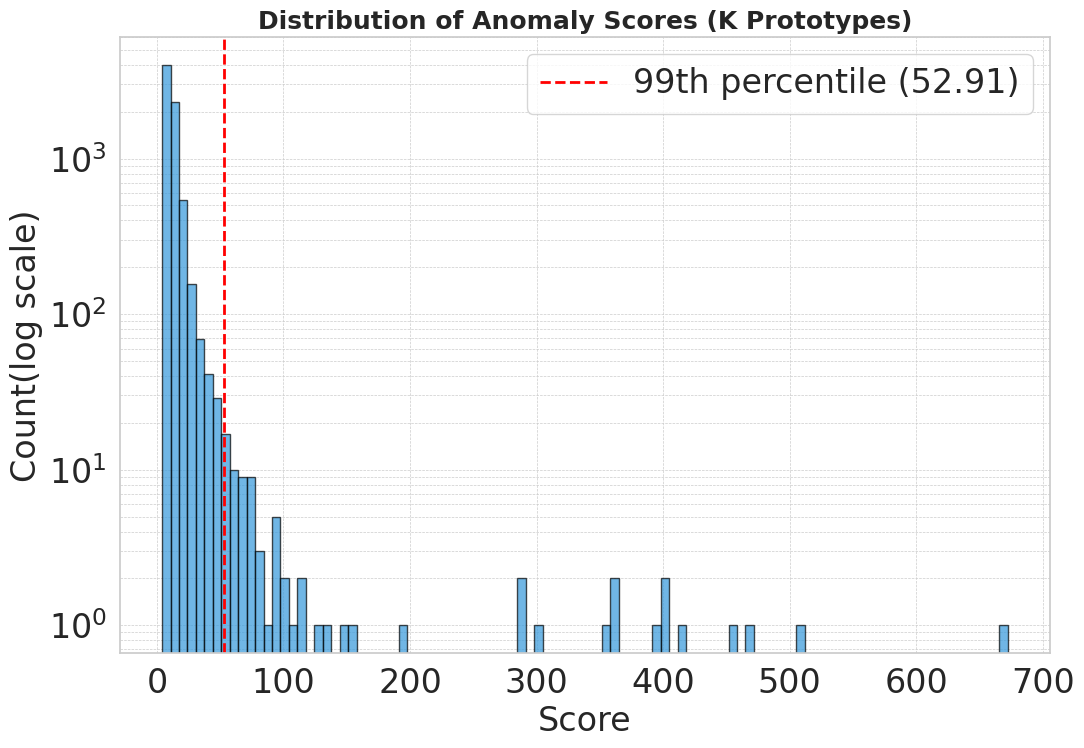

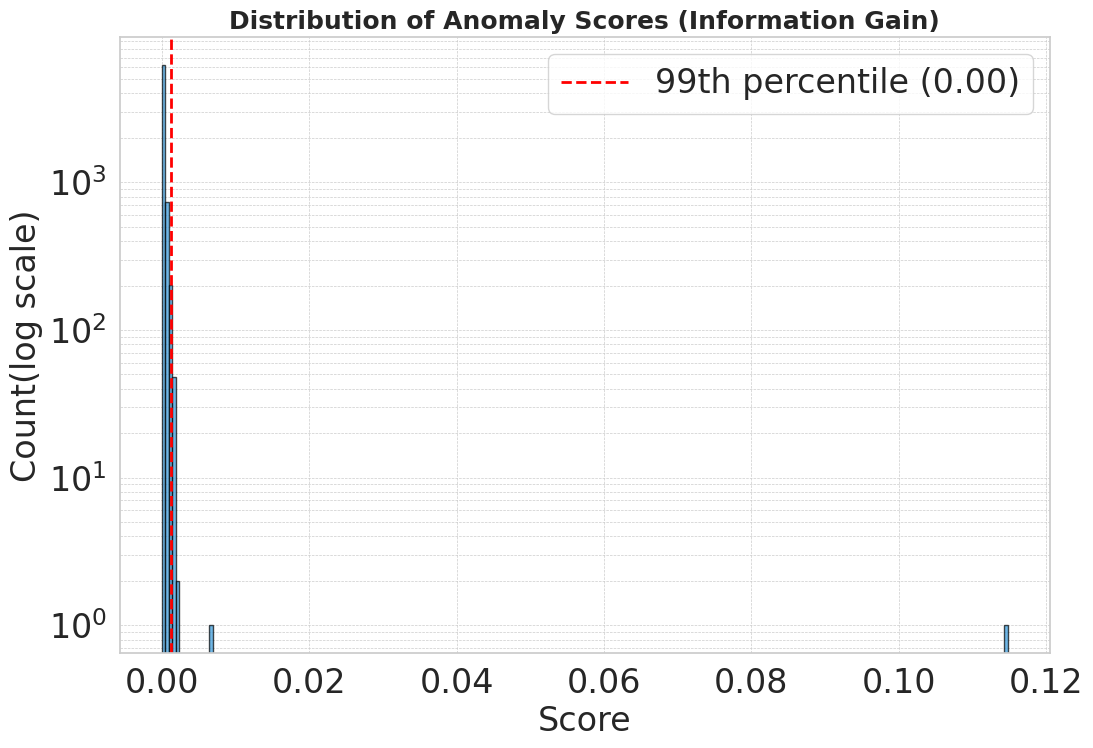

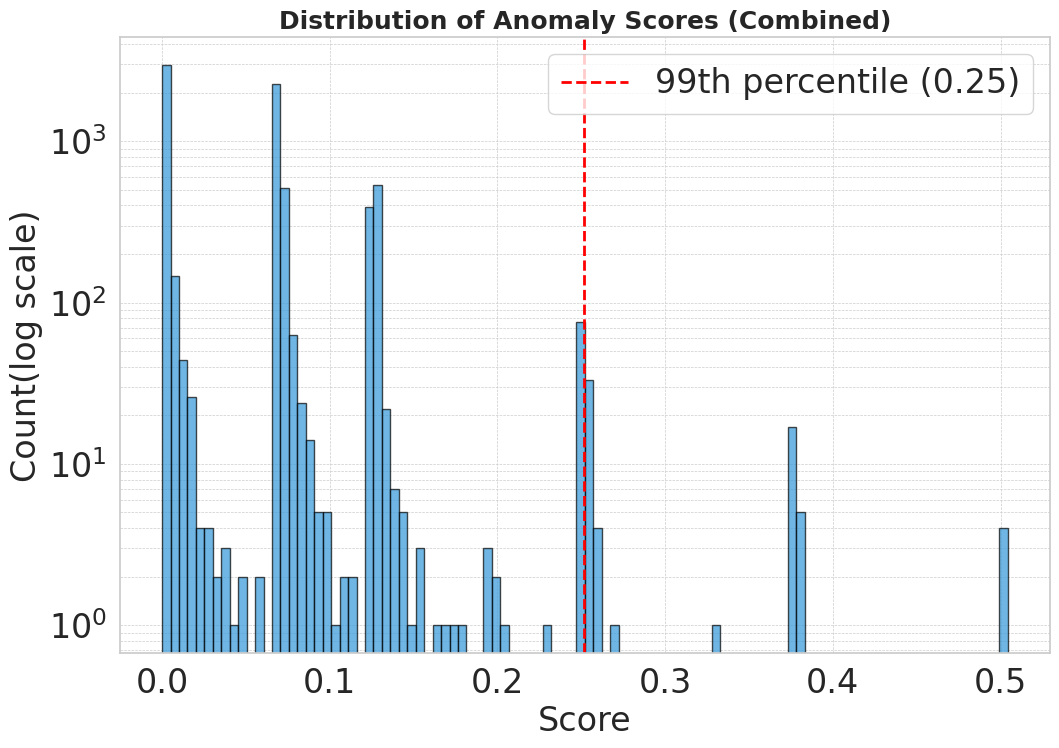

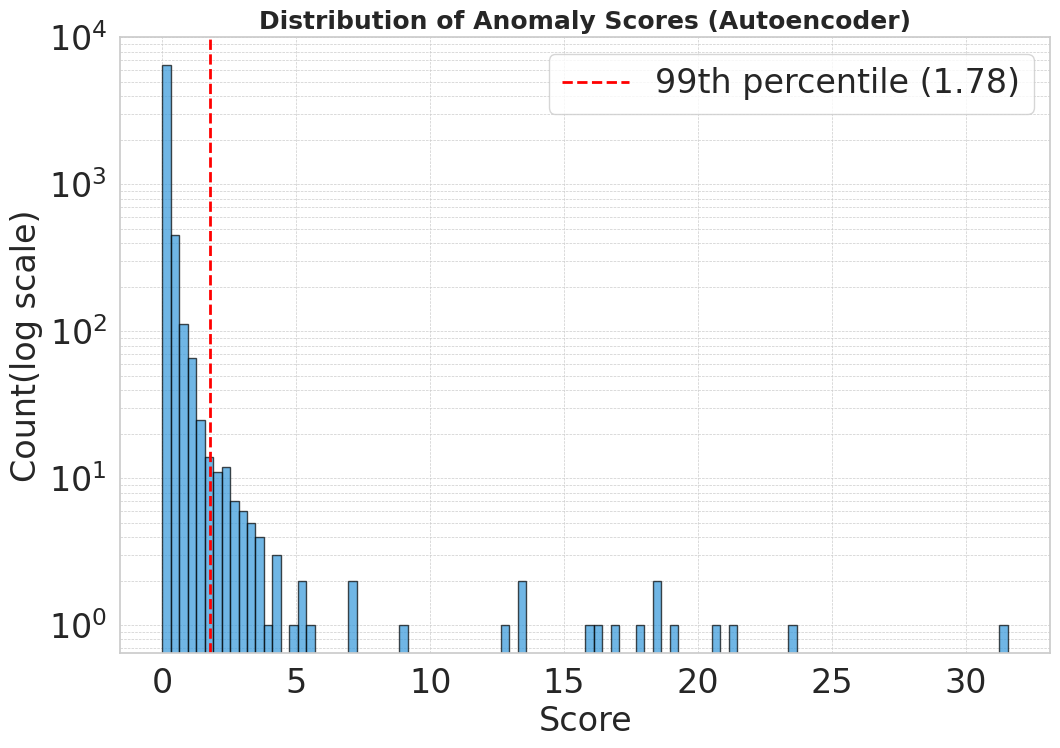

In [137]:
plot_scores_distribution(kproto.distances, 'K Prototypes')
plot_scores_distribution(igad.anomaly_scores, 'Information Gain', bins=250)
plot_scores_distribution(cad.combined_scores, 'Combined')
plot_scores_distribution(anomaly_detector.distances, 'Autoencoder')

In [133]:
def print_cluster_centroids():
    for i, centroid in enumerate(kproto.centroids):
        print(f"Centroid {i}: {centroid}")

In [134]:
print_cluster_centroids()

Centroid 0: [-0.56368519 -0.10423226  0.86942474  1.13045189  2.1859659  -0.13209075
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.        ]
Centroid 1: [-0.93681009 -0.07232638  0.04273539 -0.28364526 -0.11677147 -0.23762585
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.        ]
Centroid 2: [ 0.77742386 -0.05137342 -0.34048487 -0.30135592 -0.28102187 -0.15591165
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.        ]
Centroid 3: [-0.20556929  8.6336133  -1.509769   -2.35652108  0.55026268 -2.49156637
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          

In [174]:
final_df = anomaly_detector.display_anomalies(only_anomalies=False).copy(deep=True)

In [175]:
final_df

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20,Reconstruction_Error,Anomaly
0,0.750000,1,0,1,1,1,1,1,0,1,...,1,1,1,0.001132,0.080780,0.197324,0.300926,0.225000,0.098801,False
1,0.239583,1,1,1,1,1,1,1,1,1,...,1,1,1,0.000472,0.164345,0.235786,0.537037,0.165625,0.148333,False
2,0.479167,1,1,1,1,1,1,1,1,1,...,1,1,1,0.003585,0.130919,0.167224,0.527778,0.118750,0.079644,False
3,0.656250,0,1,1,1,1,1,1,1,1,...,1,1,1,0.001698,0.091922,0.125418,0.337963,0.129688,0.084956,False
4,0.229167,1,1,1,1,1,1,1,1,1,...,1,1,1,0.000472,0.142061,0.229097,0.337963,0.235938,0.125412,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.604167,1,1,1,1,1,1,1,1,1,...,1,1,0,0.004717,0.113092,0.128763,0.379630,0.121875,0.083845,False
7196,0.520833,1,1,1,1,1,1,1,1,1,...,1,1,1,0.200000,0.030641,0.005017,0.333333,0.005469,1.550568,False
7197,0.520833,1,1,1,1,1,1,1,1,1,...,1,1,0,0.001434,0.109192,0.147157,0.231481,0.206250,0.149822,False
7198,0.354167,0,1,1,1,1,1,1,1,1,...,1,1,1,0.005283,0.109192,0.147157,0.333333,0.154688,0.068663,False


In [176]:
# Normalize the reconstruction error to the range [0, 1]
max_error = final_df['Reconstruction_Error'].max()
min_error = final_df['Reconstruction_Error'].min()
final_df['normalized_error'] = (final_df['Reconstruction_Error'] - min_error) / (max_error - min_error)

threshold = anomaly_detector.threshold
threshold = (threshold - min_error)/(max_error - min_error)
# Calculate the probability of being anomalous
# If the normalized error is above the threshold, set probability to 1, otherwise scale it
final_df['Reconstruction_Error'] = np.where(final_df['Anomaly'] == True, 1, final_df['normalized_error'] / threshold)
final_df.drop(columns=['normalized_error'], inplace=True)
final_df.drop(columns=['Anomaly'], inplace=True)


Text(0, 0.5, 'Count (log scale)')

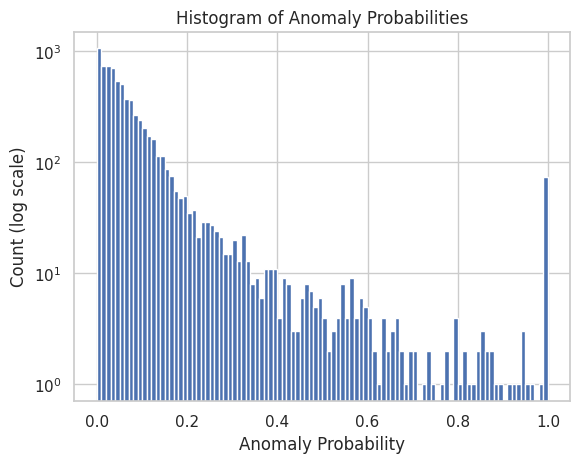

In [181]:
final_df['Reconstruction_Error'].hist(bins=100, log=True)
plt.title('Histogram of Anomaly Probabilities')
plt.xlabel('Anomaly Probability')
plt.ylabel('Count (log scale)')

In [184]:
final_df.rename(columns={'Reconstruction_Error': 'Anomaly Probability'}, inplace=True)
final_df

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_12=0,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20,Anomaly Probability
0,0.750000,1,0,1,1,1,1,1,0,1,...,1,1,1,1,0.001132,0.080780,0.197324,0.300926,0.225000,0.054799
1,0.239583,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0.000472,0.164345,0.235786,0.537037,0.165625,0.082618
2,0.479167,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0.003585,0.130919,0.167224,0.527778,0.118750,0.044039
3,0.656250,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0.001698,0.091922,0.125418,0.337963,0.129688,0.047023
4,0.229167,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0.000472,0.142061,0.229097,0.337963,0.235938,0.069745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.604167,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0.004717,0.113092,0.128763,0.379630,0.121875,0.046399
7196,0.520833,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0.200000,0.030641,0.005017,0.333333,0.005469,0.870174
7197,0.520833,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0.001434,0.109192,0.147157,0.231481,0.206250,0.083454
7198,0.354167,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0.005283,0.109192,0.147157,0.333333,0.154688,0.037872


In [185]:
final_df.to_csv('final_predictions.csv', index=False)

Artificial dataset

In [93]:
from scipy.stats import skewnorm, expon, norm, beta, triang, gamma, lognorm

def generate_skewed_data(size, skewness):
    return skewnorm.rvs(a=skewness, size=size)

def generate_exponential_data(size, scale):
    return expon.rvs(scale=scale, size=size)

def generate_normal_data(size, mean, std):
    return norm.rvs(loc=mean, scale=std, size=size)

def generate_lognormal_data(size, mean, sigma):
    return lognorm.rvs(sigma, scale=np.exp(mean), size=size)


np.random.seed(42)
n_objects = 7200
binary_indices = list(range(1, 16))
continuous_indices = [0] + list(range(-5, 0))

continuous_data = np.zeros((n_objects, len(continuous_indices)))

# Normal distribution
continuous_data[:, 0] = generate_normal_data(n_objects, 0.5, 0.1)

# Exponential data
continuous_data[:, 5] = generate_exponential_data(n_objects, 0.01)

# Different distributions centered near 0.1-0.3
continuous_data[:, 1] = beta.rvs(a=0.1, b=20, size=n_objects) # Beta distribution
continuous_data[:, 2] = gamma.rvs(a=0.1, scale=0.05, size=n_objects) + 0.1  # Gamma distribution
continuous_data[:, 3] = generate_lognormal_data(n_objects, mean=-3, sigma=0.5) * 0.2 + 0.1  # Log-normal distribution
continuous_data[:, 4] = gamma.rvs(a=20, scale=0.05, size=n_objects) + 0.1  # Gamma distribution


# Normalize all continuous data to [0,1]
continuous_data = (continuous_data - continuous_data.min(axis=0)) / (continuous_data.max(axis=0) - continuous_data.min(axis=0))
# Generate binary data with different proportions
binary_data = np.zeros((n_objects, len(binary_indices)))
proportions = np.linspace(0.15, 0.003, 15)
for i, prop in enumerate(proportions):
    binary_data[:, i] = np.random.choice([0, 1], size=n_objects, p=[prop, 1-prop])

# Combine continuous and binary data
data = np.hstack((continuous_data, binary_data))

# Turn some objects into outliers (5%)
n_outliers = int(0.05 * n_objects)
outlier_indices = np.random.choice(np.arange(n_objects), size=n_outliers, replace=False)

# Introduce outliers by flipping binary values and adding noise to continuous data
data_with_outliers = data.copy()
for idx in outlier_indices:
    # Flip binary values
    data_with_outliers[idx, len(continuous_indices):] = 1 - data_with_outliers[idx, len(continuous_indices):]
    # Add noise to continuous data
    data_with_outliers[idx, :len(continuous_indices)] += np.random.normal(0, 0.5, len(continuous_indices))

# Clip continuous data to stay within [0,1]
data_with_outliers[:, :len(continuous_indices)] = np.clip(data_with_outliers[:, :len(continuous_indices)], 0, 1)

columns = [f'cont_{i}' for i in range(len(continuous_indices))] + [f'bin_{i}' for i in range(len(binary_indices))]
df = pd.DataFrame(data_with_outliers, columns=columns)
outlier_indices_list = list(outlier_indices)

In [94]:
cols_to_move = columns[1:6]
remaining_cols = columns[:1] + columns[6:]
new_columns_order = remaining_cols + cols_to_move
df = df[new_columns_order]

In [95]:
df

,cont_0,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,...,bin_10,bin_11,bin_12,bin_13,bin_14,cont_1,cont_2,cont_3,cont_4,cont_5
0,0.521518,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,7.668304e-03,1.972908e-06,0.140276,0.417370,0.130286
1,0.432927,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.725399e-01,1.866779e-03,0.317139,0.205958,0.316733
2,0.542582,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.124300e-05,3.018020e-05,0.164192,0.286465,0.029537
3,0.664708,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.011289e-02,3.748919e-02,0.122732,0.139064,0.144369
4,0.419548,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,8.369823e-06,8.883822e-06,0.299762,0.425611,0.077469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.493776,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,4.872177e-05,2.264183e-13,0.120329,0.342855,0.156272
7196,0.515022,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.627491e-02,2.483714e-02,0.240296,0.399649,0.248985
7197,0.437657,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,4.160658e-02,4.235462e-03,0.135142,0.389377,0.028141
7198,0.699931,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.741368e-19,1.765436e-02,0.152805,0.501379,0.023176


In [96]:
continuous_columns = df.iloc[:, [0] + list(range(-5, 0))]
continuous_indices = [0] + list(range(-5, 0))
binary_columns = df.drop(continuous_columns.columns, axis=1)
binary_indices = list(range(1, 16))

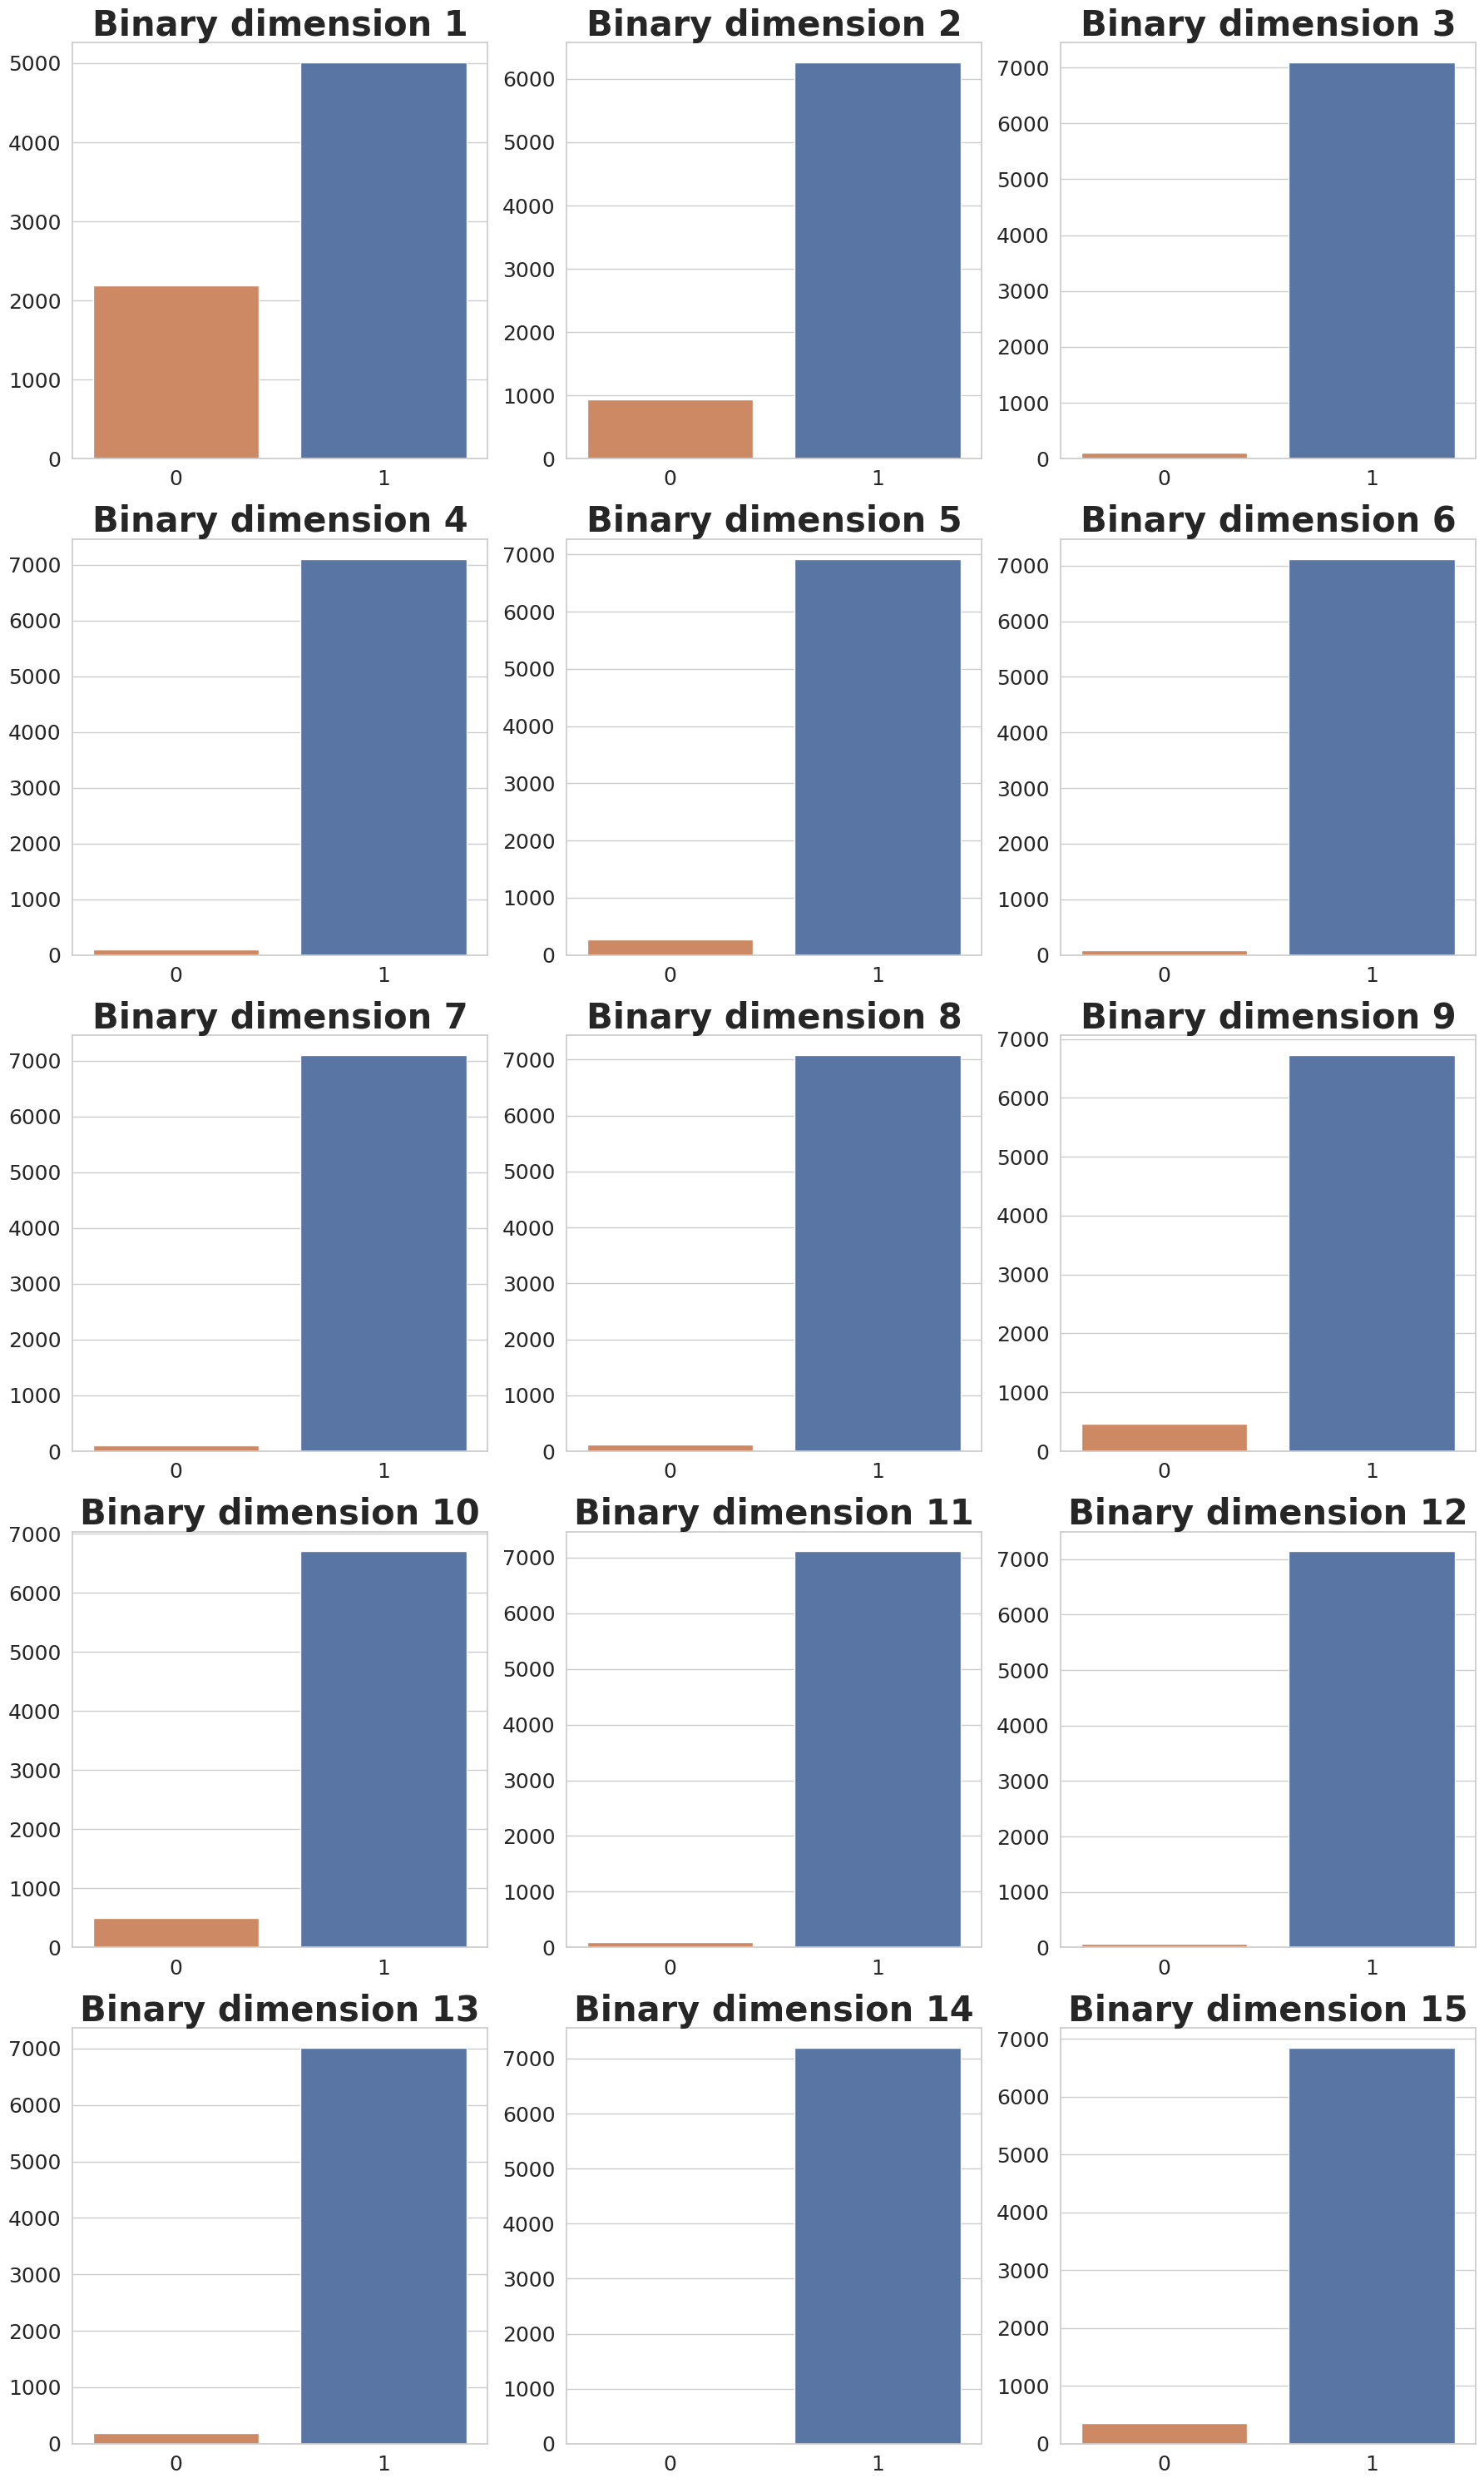

In [97]:
# plot the binary columns counts
num_plots = len(binary_columns.columns)
num_rows = (num_plots // 3) + (num_plots % 3 > 0)
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6*num_rows))
axes = axes.flatten()

def rename_column(column):
    return column.replace('Dim_', 'Binary dimension ').replace('=0', '')

for i, (column, counts) in enumerate(binary_counts.items()):
    sns.barplot(x=counts.index, y=counts.values, hue=[0, 1], ax=axes[i], palette="deep")
    axes[i].set_title(rename_column(column), fontsize=30, weight='bold')
    axes[i].set(xlabel=None)
    axes[i].tick_params(axis='both', which='major', labelsize=18)
    axes[i].legend([],[], frameon=False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

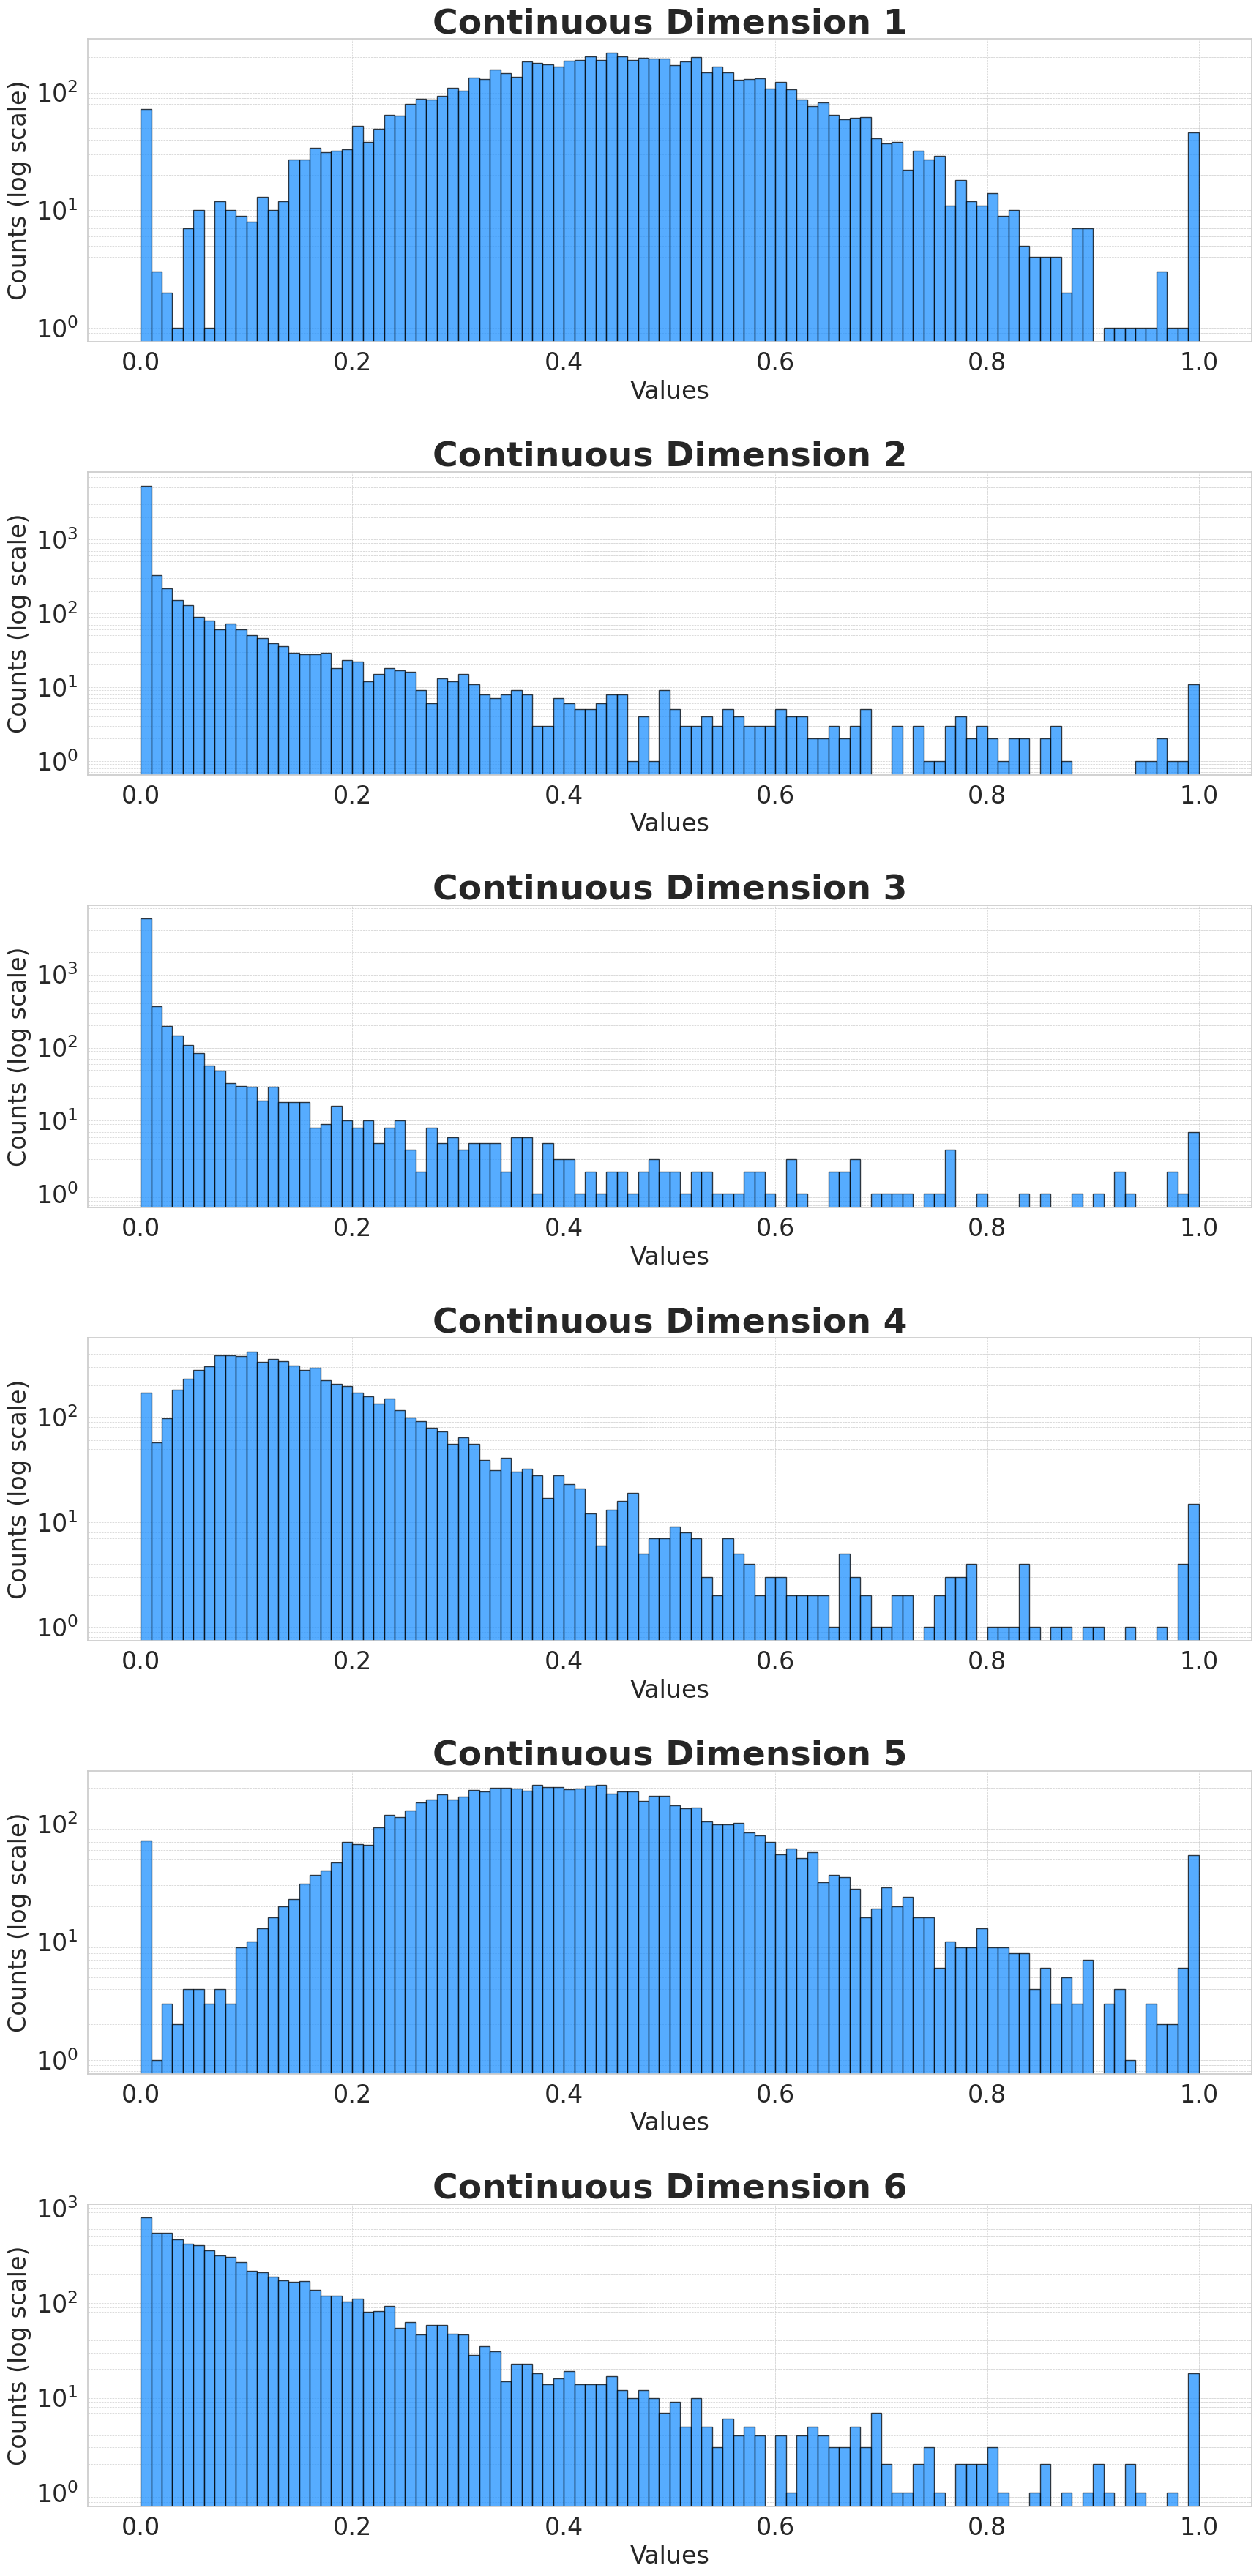

In [98]:
# plot the distribution of continuous values
num_columns = len(continuous_columns.columns)
plt.figure(figsize=(18, 6 * num_columns))

for i, column in enumerate(continuous_columns.columns):
    plt.subplot(num_columns, 1, i + 1)
    plt.hist(continuous_columns[column], bins=100, alpha=0.75, color='dodgerblue', edgecolor='black', log=True)
    plt.title(f'Continuous Dimension {i + 1}', fontsize=34, weight='bold')
    plt.xlabel('Values', fontsize=24)
    plt.ylabel('Counts (log scale)', fontsize=24)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

plt.tight_layout(pad=3.0)
plt.show()

In [99]:
kproto = KProto(df, binary_indices, continuous_indices)
kproto.fit(5, n_init=10)
kproto.find_anomalies(threshold_percentile=95)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1712, ncost: 34610.277220700205
Run: 1, iteration: 2/100, moves: 705, ncost: 34023.18229156591
Run: 1, iteration: 3/100, moves: 376, ncost: 33740.67296968215
Run: 1, iteration: 4/100, moves: 198, ncost: 33660.70412756721
Run: 1, iteration: 5/100, moves: 148, ncost: 33630.89350728252
Run: 1, iteration: 6/100, moves: 106, ncost: 33620.193248135845
Run: 1, iteration: 7/100, moves: 64, ncost: 33613.07201108415
Run: 1, iteration: 8/100, moves: 45, ncost: 33611.51518810855
Run: 1, iteration: 9/100, moves: 45, ncost: 33610.09218930548
Run: 1, iteration: 10/100, moves: 34, ncost: 33609.279536497634
Run: 1, iteration: 11/100, moves: 21, ncost: 33608.94642736727
Run: 1, iteration: 12/100, moves: 15, ncost: 33608.63070346315
Run: 1, iteration: 13/100, moves: 15, ncost: 33608.47828255365
Run: 1, iteration: 14/100, moves: 12, ncost: 33608.28910763381
Run: 1, iteration: 15/100, moves: 18,

array([False, False, False, ..., False, False, False])

In [100]:
igad = InformationGainAnomalyDetection(df, binary_indices, continuous_indices)
igad.fit(bins=50)
anomalies = igad.find_anomalies(threshold_percentile=95)

In [101]:
cad = CombinedAnomalyDetection(df, binary_indices, continuous_indices)
cad.fit(n_clusters=5, n_init=10)
anomalies = cad.find_anomalies(threshold_percentile=95)

In [102]:
anomaly_detector = AutoencoderAnomalyDetection(data=df, continuous_indices=continuous_indices)
anomaly_detector.fit(encoding_dim=10, epochs=100, batch_size=16)
anomalies = anomaly_detector.find_anomalies(threshold_percentile=95)

Epoch 1/100, Loss: 0.3459686892893579
Epoch 2/100, Loss: 0.30136272420485816
Epoch 3/100, Loss: 0.28372257709503174
Epoch 4/100, Loss: 0.27350488970677056
Epoch 5/100, Loss: 0.26880398992035126
Epoch 6/100, Loss: 0.26360010570949977
Epoch 7/100, Loss: 0.2612799731559224
Epoch 8/100, Loss: 0.2597140730751885
Epoch 9/100, Loss: 0.25823403947883183
Epoch 10/100, Loss: 0.2572255677150355
Epoch 11/100, Loss: 0.25666659909817907
Epoch 12/100, Loss: 0.2560401437183221
Epoch 13/100, Loss: 0.25574809153874717
Epoch 14/100, Loss: 0.2544680056307051
Epoch 15/100, Loss: 0.2543152974214819
Epoch 16/100, Loss: 0.25358239312966663
Epoch 17/100, Loss: 0.2526004291905297
Epoch 18/100, Loss: 0.25224117192957135
Epoch 19/100, Loss: 0.2517484645048777
Epoch 20/100, Loss: 0.2517214524414804
Epoch 21/100, Loss: 0.2507973521285587
Epoch 22/100, Loss: 0.25075141019291347
Epoch 23/100, Loss: 0.24962511046065225
Epoch 24/100, Loss: 0.25035151281290585
Epoch 25/100, Loss: 0.24970163262552686
Epoch 26/100, Loss: 

In [103]:
# Get indices
indices_kproto = set(kproto.display_anomalies(only_anomalies=True).index)  # K prototypes approach for anomaly detection
indices_info_based = set(igad.display_anomalies(only_anomalies=True).index)  # Information based
indices_combined = set(cad.display_anomalies(only_anomalies=True).index)  # Combined of 1 and 2
indices_vae = set(anomaly_detector.display_anomalies(only_anomalies=True).index)  # Variational autoencoder

# Find common indices
common_indices = indices_kproto & indices_info_based & indices_combined & indices_vae
common_indices_12 = indices_kproto & indices_info_based
common_indices_13 = indices_kproto & indices_combined
common_indices_14 = indices_kproto & indices_vae
common_indices_23 = indices_info_based & indices_combined
common_indices_24 = indices_info_based & indices_vae
common_indices_34 = indices_combined & indices_vae
common_indices_123 = indices_kproto & indices_info_based & indices_combined
common_indices_124 = indices_kproto & indices_info_based & indices_vae
common_indices_134 = indices_kproto & indices_combined & indices_vae
common_indices_234 = indices_info_based & indices_combined & indices_vae

# Display results
print("Common Indices among all:", len(common_indices), common_indices)
print("Common Indices between K prototypes approach for anomaly detection and Information based:", len(common_indices_12), common_indices_12)
print("Common Indices between K prototypes approach for anomaly detection and Combined:", len(common_indices_13), common_indices_13)
print("Common Indices between K prototypes approach for anomaly detection and Autoencoder:", len(common_indices_14), common_indices_14)
print("Common Indices between Information based and Combined:", len(common_indices_23), common_indices_23)
print("Common Indices between Information based and Autoencoder:", len(common_indices_24), common_indices_24)
print("Common Indices between Combined and Autoencoder:", len(common_indices_34), common_indices_34)
print("Common Indices between K prototypes approach for anomaly detection, Information based, and Combined:", len(common_indices_123), common_indices_123)
print("Common Indices between K prototypes approach for anomaly detection, Information based, and Autoencoder:", len(common_indices_124), common_indices_124)
print("Common Indices between K prototypes approach for anomaly detection, Combined, and Autoencoder:", len(common_indices_134), common_indices_134)
print("Common Indices between Information based, Combined, and Autoencoder:", len(common_indices_234), common_indices_234)

Common Indices among all: 107 {1026, 1032, 3593, 2582, 23, 1558, 27, 6171, 4649, 43, 2095, 5167, 3126, 4151, 4673, 3655, 4170, 84, 6233, 5739, 5229, 3698, 3197, 1661, 6271, 1663, 1677, 5268, 1685, 3734, 159, 6816, 2727, 6828, 1200, 5299, 183, 703, 5314, 3783, 4304, 6371, 740, 6373, 2789, 5859, 5354, 6893, 4850, 5369, 5886, 2825, 4874, 6922, 272, 3345, 1302, 5910, 4384, 4395, 303, 5935, 2871, 2369, 3905, 6980, 3910, 4431, 1879, 2392, 2400, 1905, 4466, 6516, 2421, 1398, 4473, 4475, 2432, 901, 6534, 3974, 3978, 3979, 5005, 910, 1937, 1428, 5019, 6563, 1452, 1968, 1460, 2487, 2488, 3013, 4551, 6095, 6610, 3035, 4062, 2026, 4594, 7156, 5111, 1528, 1017}
Common Indices between K prototypes approach for anomaly detection and Information based: 121 {1026, 1032, 3593, 2582, 23, 1558, 27, 6171, 4649, 43, 2095, 5167, 3126, 4151, 3645, 4673, 3655, 4170, 84, 2132, 6233, 5739, 5229, 3698, 3197, 1661, 6271, 1663, 3716, 1677, 5268, 1685, 3733, 3734, 159, 6816, 2727, 6828, 1200, 5299, 183, 703, 5314, 1

In [104]:
# Correctly detected outliers
correctly_detected_kproto = indices_kproto & set(outlier_indices_list)
correctly_detected_info_based = indices_info_based & set(outlier_indices_list)
correctly_detected_combined = indices_combined & set(outlier_indices_list)
correctly_detected_ae = indices_vae & set(outlier_indices_list)

# Print results
print(f"Correctly detected outliers by K prototypes approach for anomaly detection: {len(correctly_detected_kproto)} / {n_outliers}")
print(f"Correctly detected outliers by Information based: {len(correctly_detected_info_based)} / {n_outliers}")
print(f"Correctly detected outliers by Combined of 1 and 2: {len(correctly_detected_combined)} / {n_outliers}")
print(f"Correctly detected outliers by autoencoder: {len(correctly_detected_ae)} / {n_outliers}")

Correctly detected outliers by K prototypes approach for anomaly detection: 295 / 360
Correctly detected outliers by Information based: 140 / 360
Correctly detected outliers by Combined of 1 and 2: 360 / 360
Correctly detected outliers by autoencoder: 261 / 360


In [123]:
def plot_scores_distribution(scores, model_name, bins=100):

    plt.figure(figsize=(12, 8))
    plt.hist(scores, bins=bins, alpha=0.7, color='#3498db', edgecolor='black', log=False)
    plt.title('Distribution of Anomaly Scores (' + model_name + ')', fontsize=18, fontweight='bold')
    plt.xlabel('Score', fontsize=24)
    plt.ylabel('Count(log scale)', fontsize=24)
    plt.yscale('log')


    threshold = np.percentile(scores, 95)
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'95th percentile ({threshold:.4f})')
    plt.legend(fontsize=24)


    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)


    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.show()

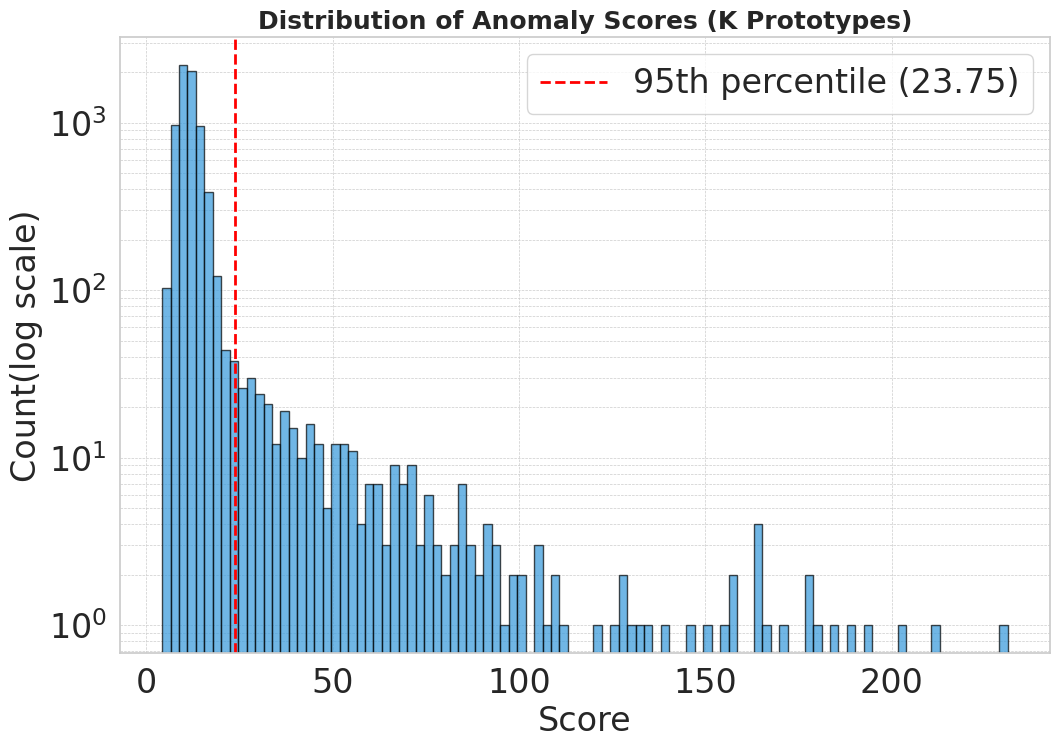

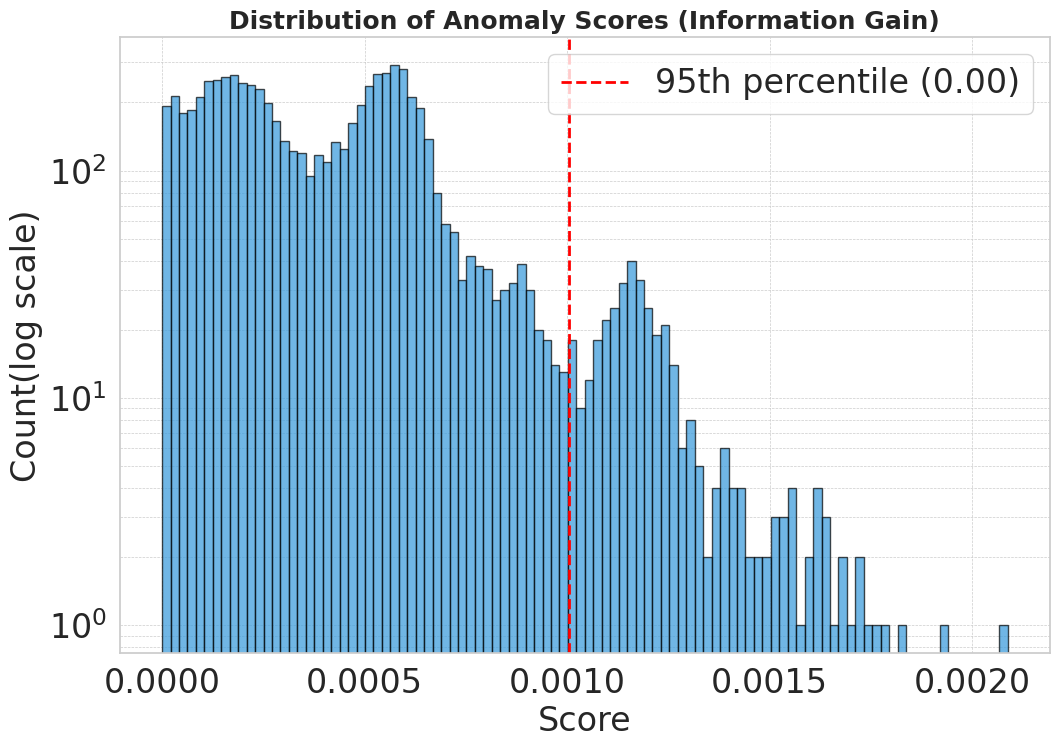

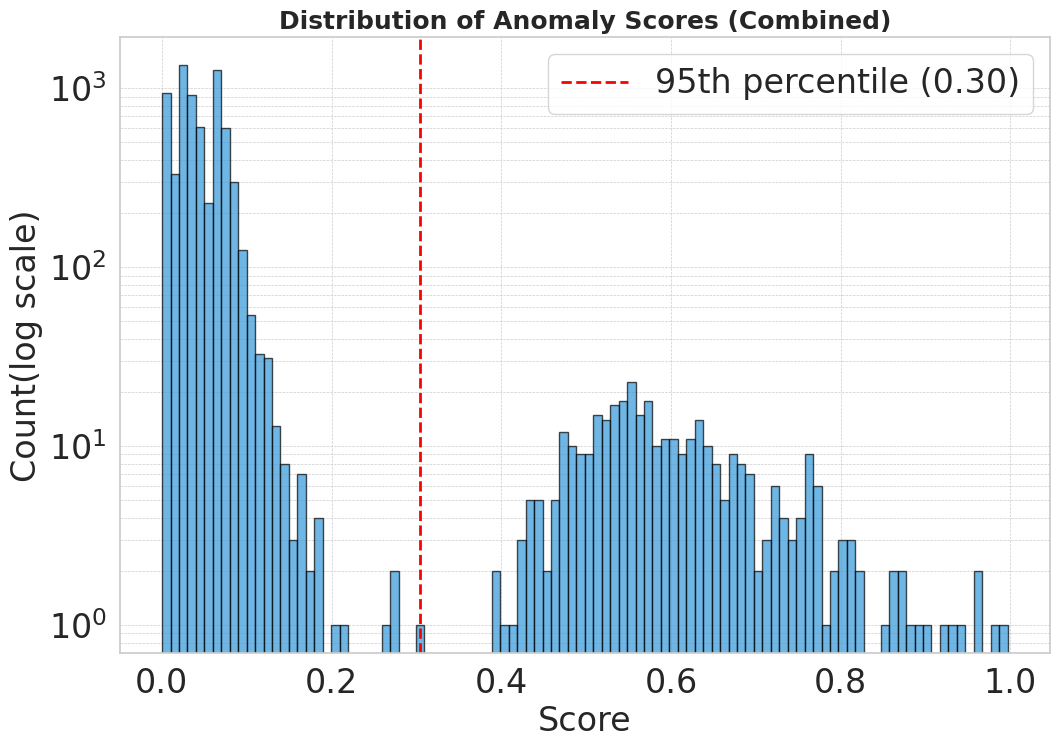

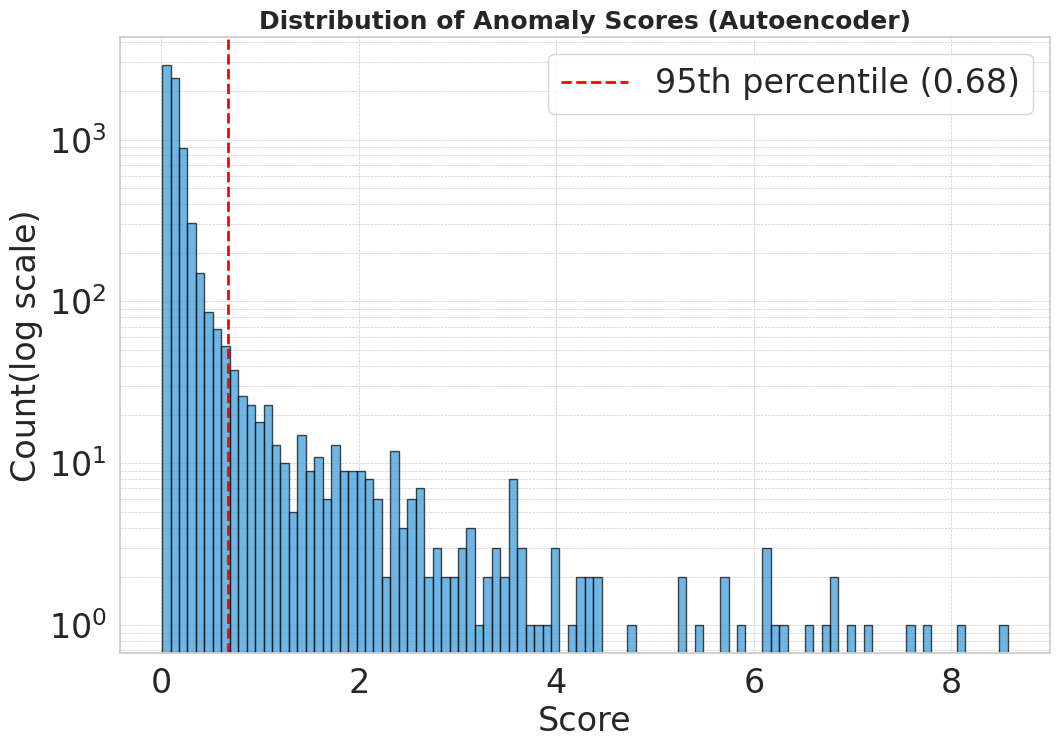

In [111]:
plot_scores_distribution(kproto.distances, 'K Prototypes')
plot_scores_distribution(igad.anomaly_scores, 'Information Gain')
plot_scores_distribution(cad.combined_scores, 'Combined')
plot_scores_distribution(anomaly_detector.distances, 'Autoencoder')